In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from matplotlib.colors import ListedColormap
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

In [2]:
def generate_datasets(n_samples=500, noise_level=0.5, class_sep = 2.5):
    datasets = {}

    scaler = MinMaxScaler()

    spread = 1  # Controls how tightly points are clustered

    # Generate Data
    X_0 = np.array([(1.1 + np.random.uniform(-spread, spread),
                     1.1 + np.random.uniform(-spread, spread)) for _ in range(n_samples // 2)])

    X_1 = np.array([(1.1 + np.random.uniform(-spread, spread),
                     -1.1 + np.random.uniform(-spread, spread)) for _ in range(n_samples // 2)])

    X_sep = np.vstack((X_0, X_1))
    y_sep = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    X_sep = scaler.fit_transform(X_sep)

    datasets['Seperated'] = (X_sep, y_sep)


    cluster_size = int(n_samples * 0.5)  # 70% of points in cluster
    line_size = n_samples - cluster_size  # Remaining points in a line

    # Generate clustered points (Class 0)
    mean_cluster = [0, 0]  # Centered at origin
    cov_cluster = [[1.5, 0.7], [0.7, 1.5]]  # Covariance for elliptical shape
    X_cluster = np.random.multivariate_normal(mean_cluster, cov_cluster, cluster_size)

    # Generate linear points (Class 1)
    x_line = np.linspace(-3, 3, line_size)  # Line from left to right
    y_line = -x_line + np.random.normal(0, noise_level, line_size)  # Small noise on line
    X_line = np.column_stack((x_line, y_line))

    # Combine datasets
    X_tl = np.vstack((X_cluster, X_line))
    y_tl = np.hstack((np.zeros(cluster_size), np.ones(line_size)))

    X_tl = scaler.fit_transform(X_tl)


    datasets['Two Lines'] = (X_tl, y_tl)

    X_moons, y_moons = make_moons(n_samples=n_samples, noise=noise_level)

    X_moons = scaler.fit_transform(X_moons)


    datasets['Moons'] = (X_moons, y_moons)

    X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.3, noise=noise_level)
    X_circles = scaler.fit_transform(X_circles)

    datasets['Circles'] = (X_circles, y_circles)

    # X_random, y_random = make_circles(n_samples=n_samples, noise=0.5, factor=0)

    X_random = np.random.random_sample((n_samples, 2))
    y_random = np.random.randint(0, 2, n_samples)
    # X_random, y_random = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1)
    X_random = scaler.fit_transform(X_random)

    datasets['Random'] = (X_random, y_random)


    X_chess = np.random.rand(n_samples, 2) * 2 - 1  # Points in range [-1, 1]



    margin = 0.1

    y_chess = ((X_chess[:, 0] * X_chess[:, 1] > margin) | (X_chess[:, 0] * X_chess[:, 1] < -margin)).astype(int)

    # X_chess = scaler.fit_transform(X_chess)
    # y_chess = scaler.fit_transform(y_chess)


    datasets['Cross'] = (X_chess, y_chess)

    return datasets


In [3]:
def plot_datasets(datasets):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, (name, (X, y)) in enumerate(datasets.items()):

        axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
        axes[i].set_title(name)

    plt.tight_layout()
    plt.show()



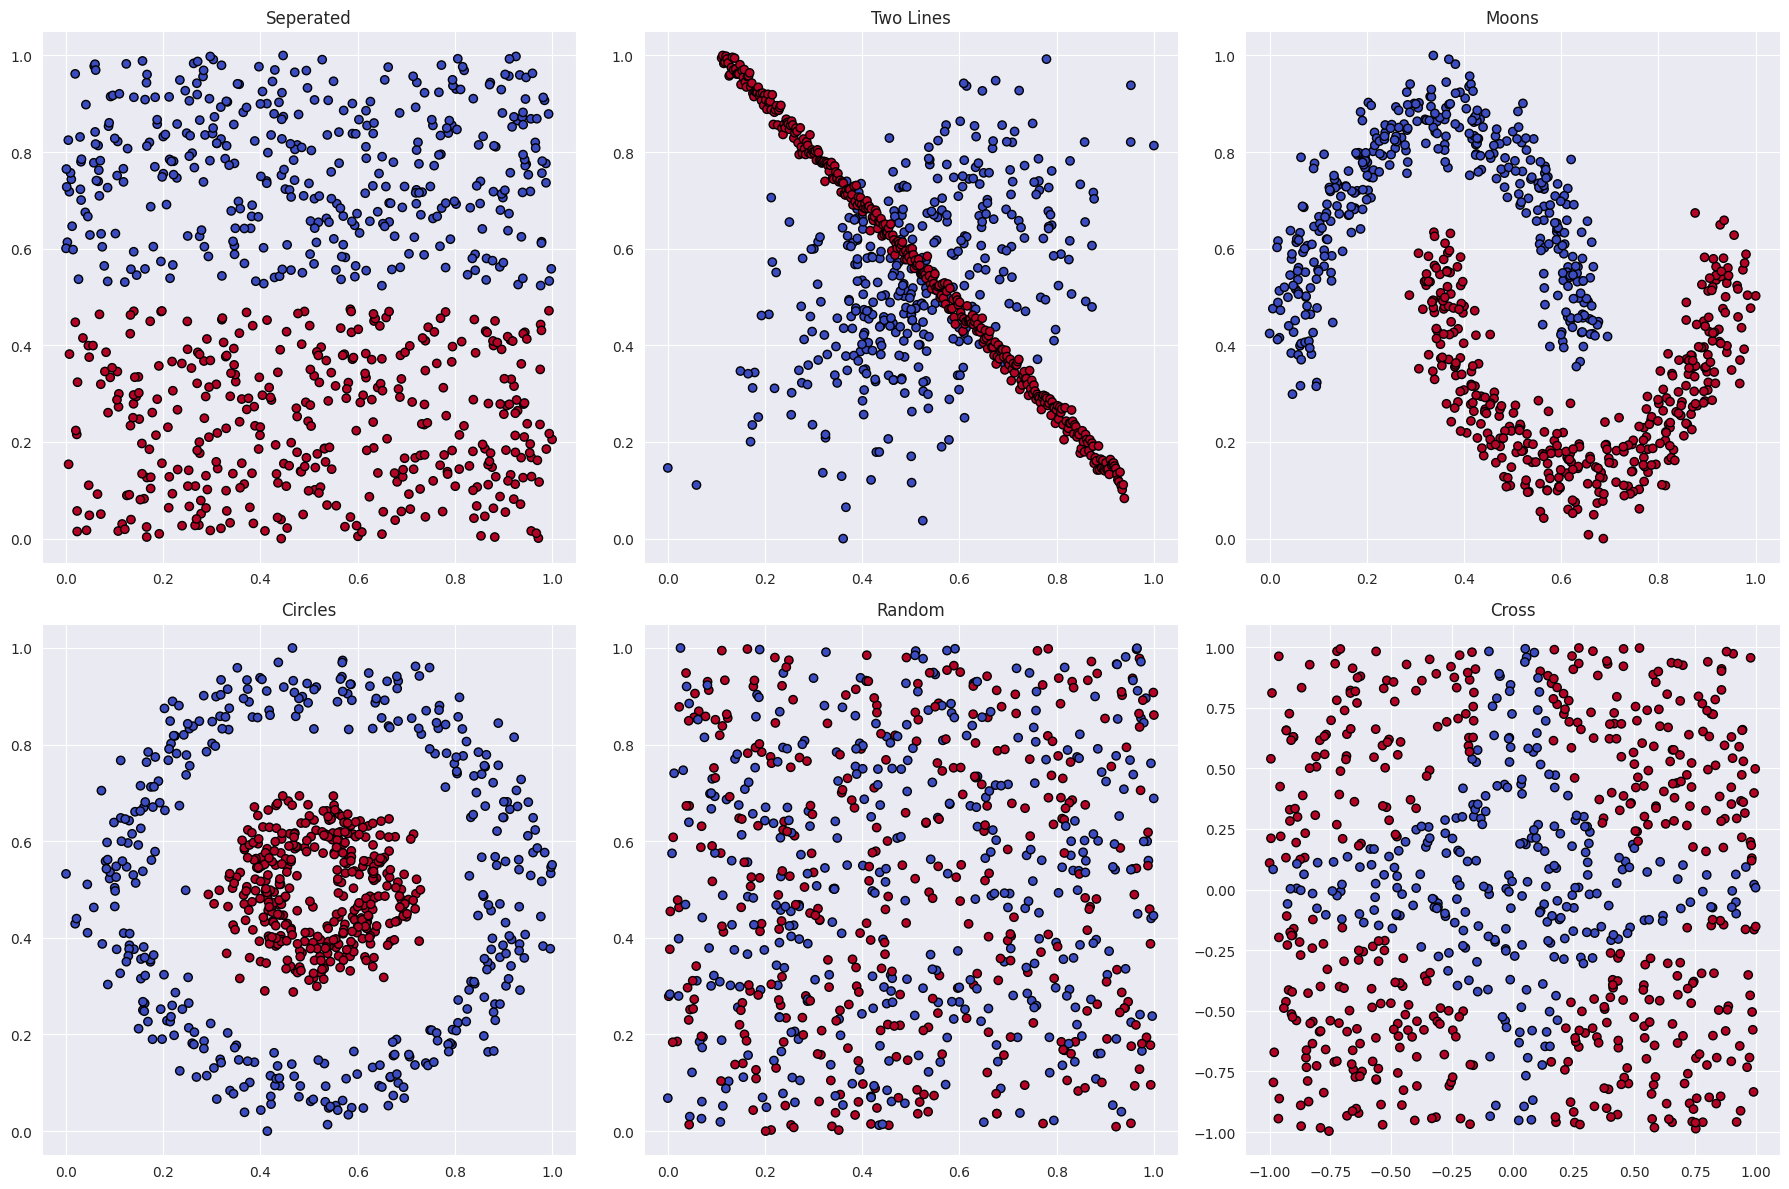

In [4]:
# Generate and plot datasets
datasets = generate_datasets(n_samples=750, noise_level=0.1)
plot_datasets(datasets)

In [5]:
def plot_decision_boundary(model, X, y, ax):
    """Plots decision boundary for a 2D dataset on a given subplot axis."""
    h = 0.02  # Step size for meshgrid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    try:
        if hasattr(model, "predict_proba"):
            Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] > 0.5
        elif hasattr(model, "decision_function"):
            Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]) > 0
        else:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

        Z = Z.reshape(xx.shape)

        # Plot decision regions
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
        ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=ListedColormap(['red', 'blue']))

        # Labels
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")

    except Exception as e:
        # ax.set_title("Error: Decision Boundary Unavailable")
        print(f"Error plotting decision boundary: {e}")


In [6]:
def evaluate_model(model, model_name, datasets):
    for name, (X, y) in datasets.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_test)
        else:
            y_prob = None

        #validação cruzada
        # scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        # print(f"\n{name} - {model_name}")
        # print(f"Accuracy (cross-validation): {scores.mean():.4f} ± {scores.std():.4f}")

        fig, axes = plt.subplots(1, 4, figsize=(20, 4))

        axes = axes.ravel()

        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')
        axes[0].set_title(f'Confusion Matrix - {name}')

        if len(np.unique(y)) == 2 and y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
            roc_auc = auc(fpr, tpr)
            axes[1].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
            axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
            axes[1].set_xlabel('False Positive Rate')
            axes[1].set_ylabel('True Positive Rate')
            axes[1].set_title(f'ROC Curve - {name}')
            axes[1].legend()
        else:
            axes[1].axis('off')  # Hide this plot if ROC is not applicable



        # Decision Boundary (Only for 2D binary classification)
        if X.shape[1] == 2 and len(np.unique(y)) == 2:
            plot_decision_boundary(model, X_test, y_pred, axes[2])
            axes[2].set_title(f"Decision Boundary (Pred) - {name} ({model_name})")
        else:
            axes[2].axis('off')

        if X.shape[1] == 2 and len(np.unique(y)) == 2:
            plot_decision_boundary(model, X_test, y_test, axes[3])
            axes[3].set_title(f"Decision Boundary (Real) - {name} ({model_name})")
        else:
            axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Classification Report {name}:")
        print(classification_report(y_test, y_pred, zero_division=1))


        if X.shape[1] == 2 and len(np.unique(y)) == 2:
            plot_decision_boundary(model, X, y, f"Decision Boundary - {name} ({model_name})")


Seperated - Logistic Regression
Accuracy (cross-validation): 1.0000 ± 0.0000


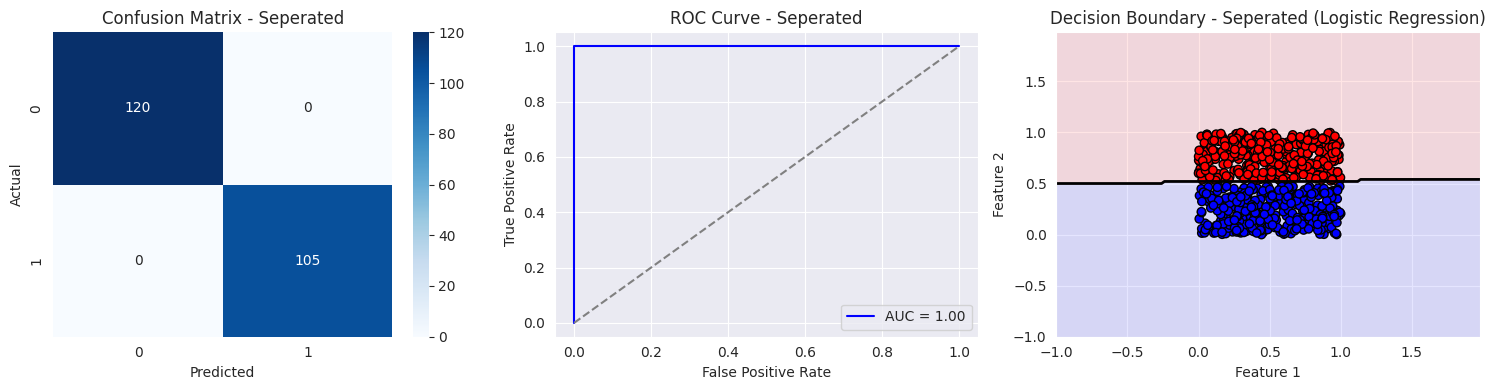

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       120
         1.0       1.00      1.00      1.00       105

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - Logistic Regression
Accuracy (cross-validation): 0.3933 ± 0.1354


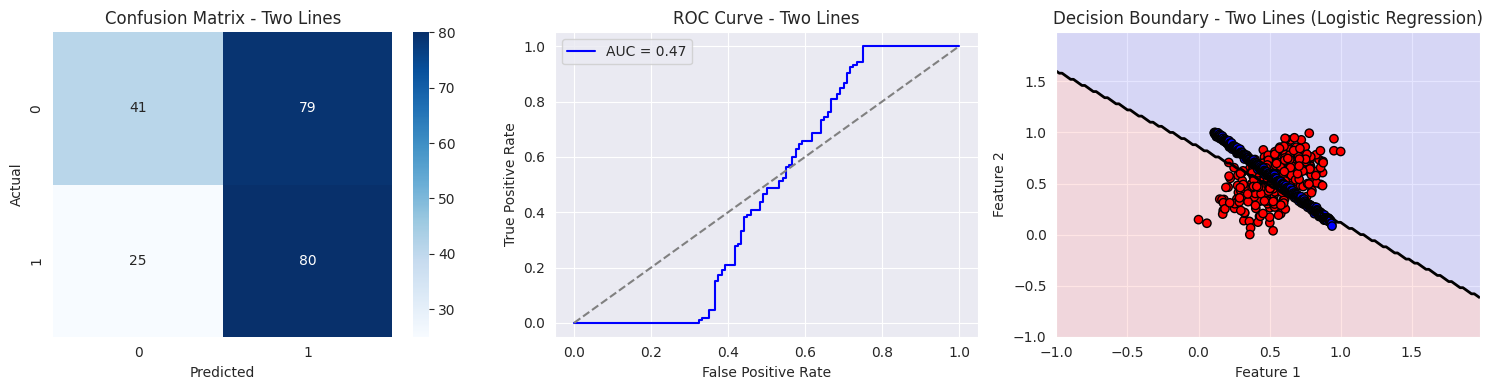

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.34      0.44       120
         1.0       0.50      0.76      0.61       105

    accuracy                           0.54       225
   macro avg       0.56      0.55      0.52       225
weighted avg       0.57      0.54      0.52       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - Logistic Regression
Accuracy (cross-validation): 0.8627 ± 0.0196


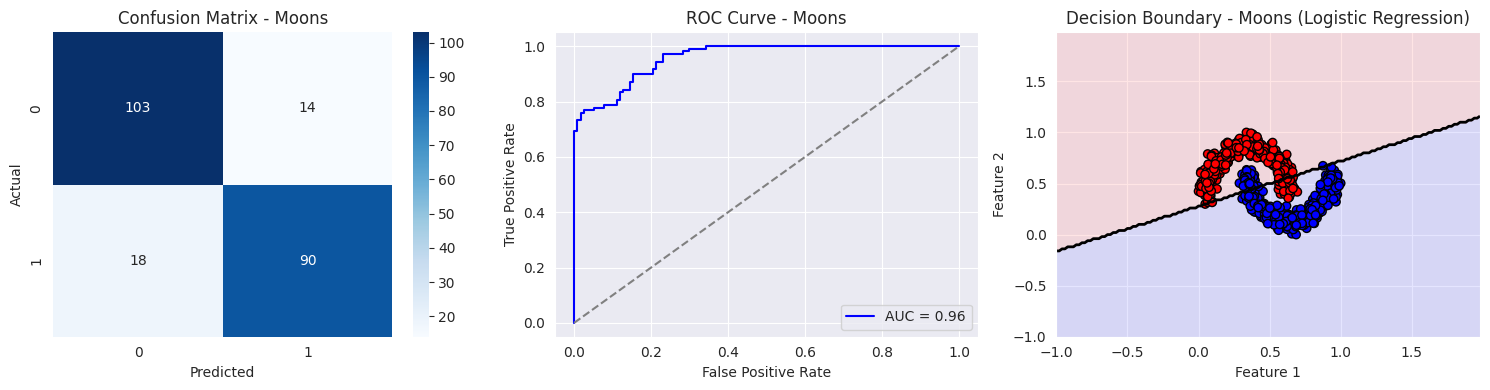

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       117
           1       0.87      0.83      0.85       108

    accuracy                           0.86       225
   macro avg       0.86      0.86      0.86       225
weighted avg       0.86      0.86      0.86       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - Logistic Regression
Accuracy (cross-validation): 0.4493 ± 0.0252


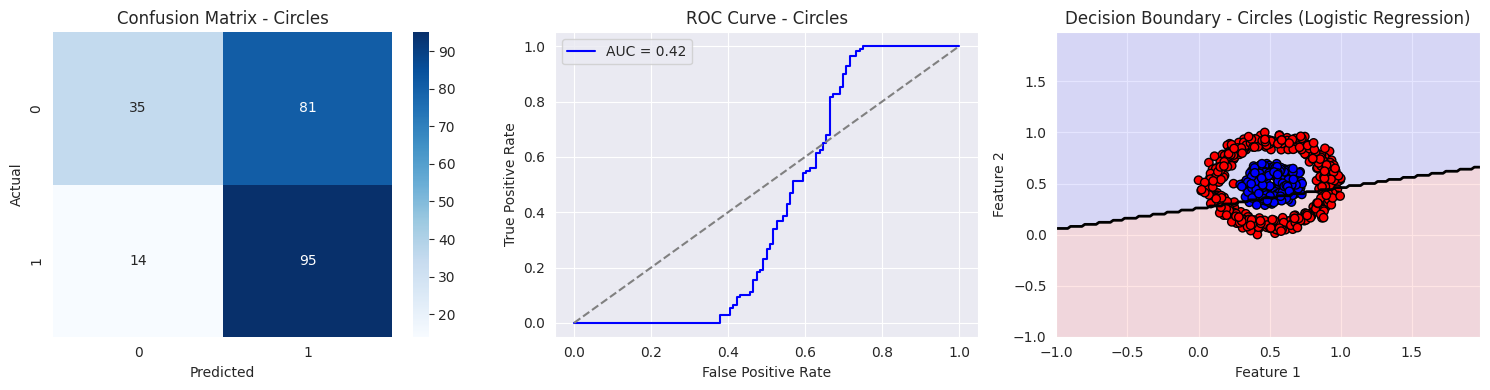

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.30      0.42       116
           1       0.54      0.87      0.67       109

    accuracy                           0.58       225
   macro avg       0.63      0.59      0.55       225
weighted avg       0.63      0.58      0.54       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - Logistic Regression
Accuracy (cross-validation): 0.5107 ± 0.0423


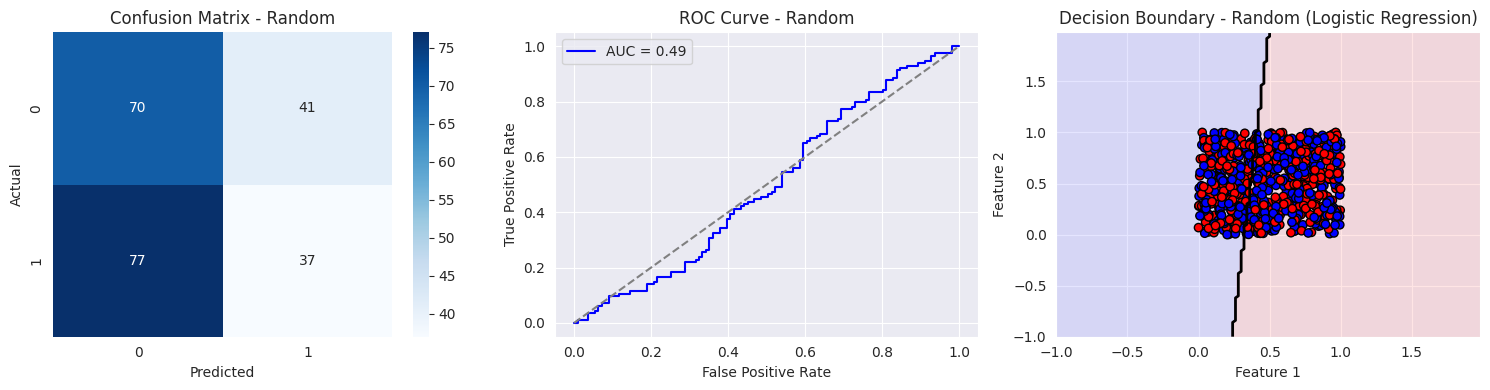

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.63      0.54       111
           1       0.47      0.32      0.39       114

    accuracy                           0.48       225
   macro avg       0.48      0.48      0.46       225
weighted avg       0.48      0.48      0.46       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Cross - Logistic Regression
Accuracy (cross-validation): 0.6467 ± 0.0000


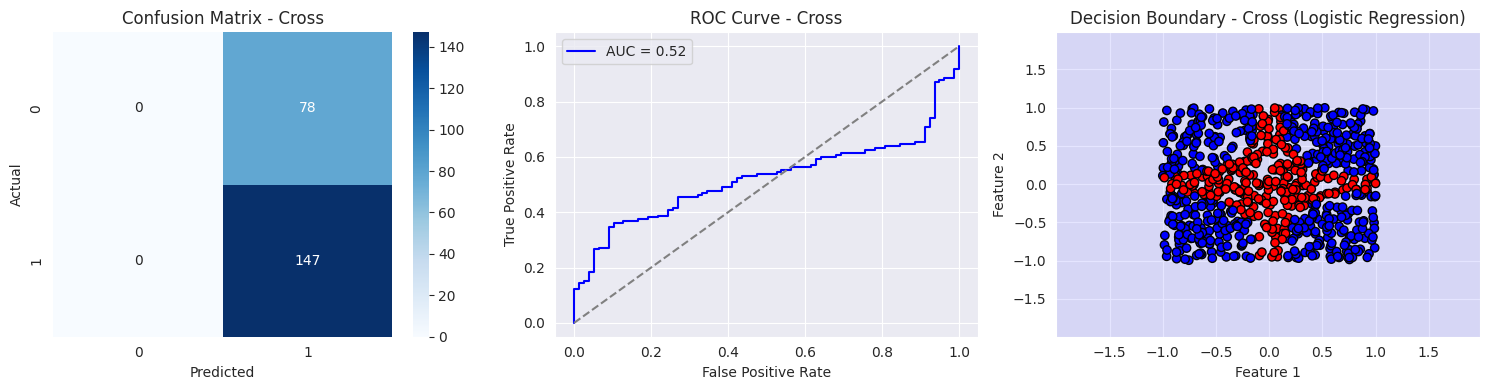

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        78
           1       0.65      1.00      0.79       147

    accuracy                           0.65       225
   macro avg       0.83      0.50      0.40       225
weighted avg       0.77      0.65      0.52       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [7]:
evaluate_model(LogisticRegression(), "Logistic Regression", datasets)


Seperated - LDA
Accuracy (cross-validation): 1.0000 ± 0.0000


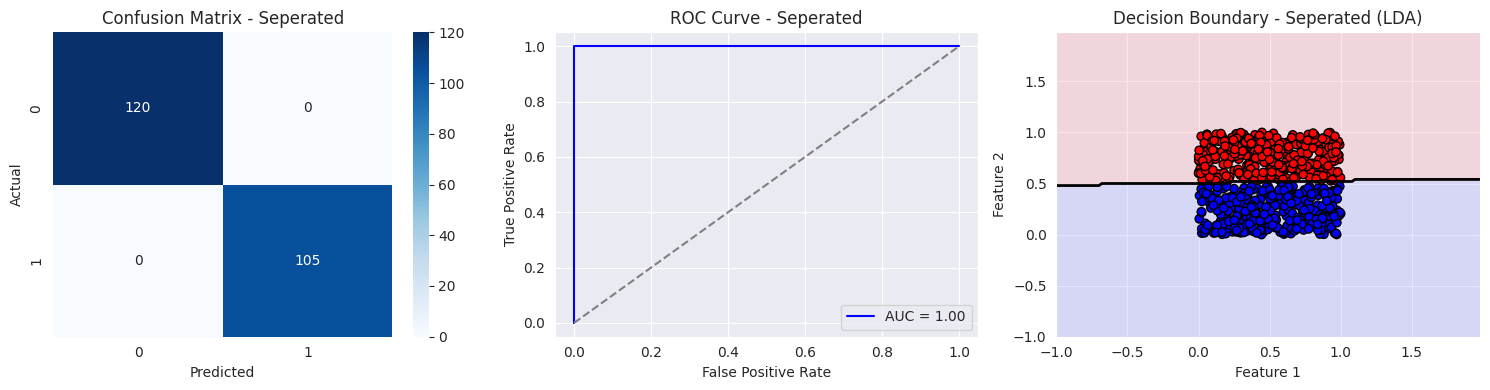

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       120
         1.0       1.00      1.00      1.00       105

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - LDA
Accuracy (cross-validation): 0.3947 ± 0.1343


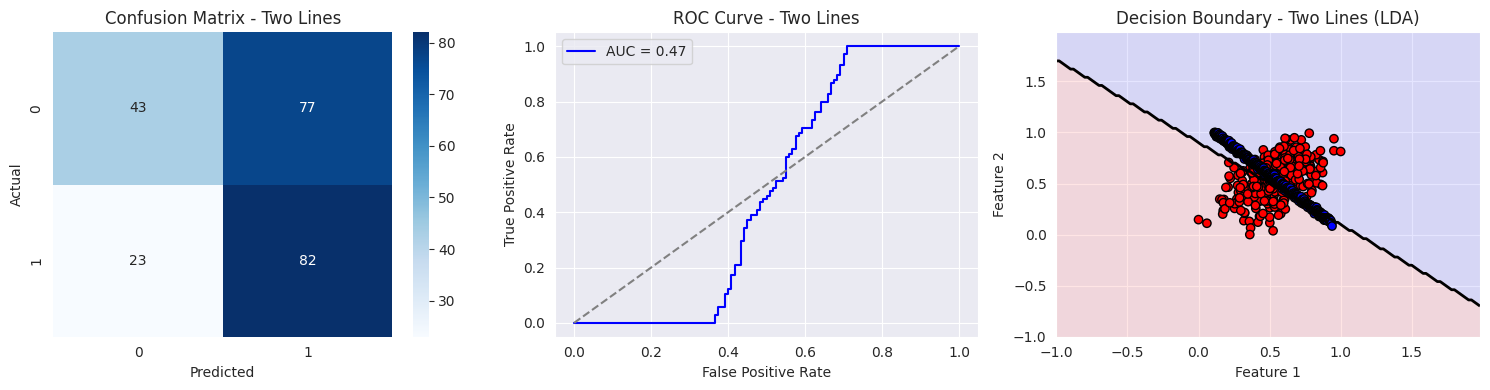

Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.36      0.46       120
         1.0       0.52      0.78      0.62       105

    accuracy                           0.56       225
   macro avg       0.58      0.57      0.54       225
weighted avg       0.59      0.56      0.54       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - LDA
Accuracy (cross-validation): 0.8640 ± 0.0150


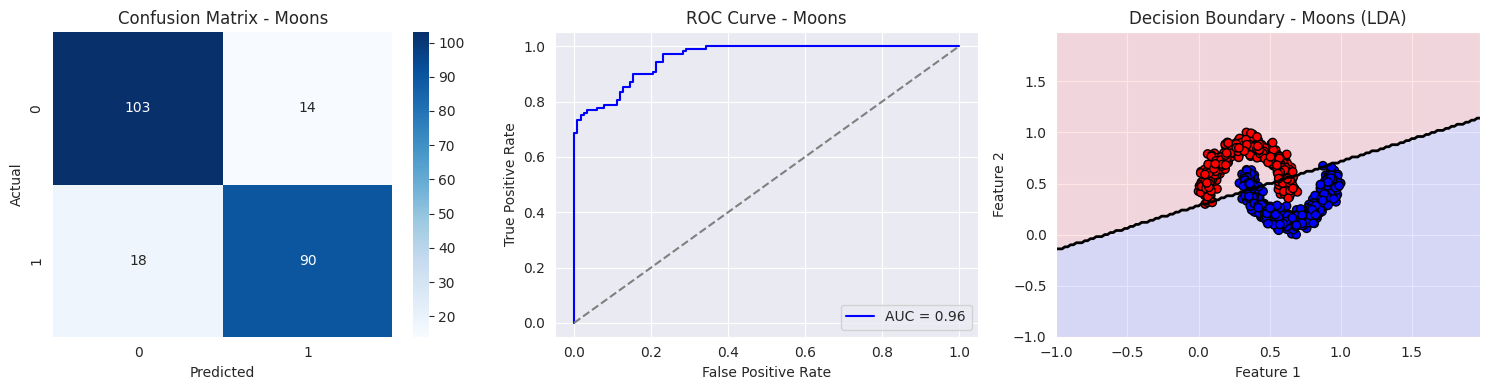

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       117
           1       0.87      0.83      0.85       108

    accuracy                           0.86       225
   macro avg       0.86      0.86      0.86       225
weighted avg       0.86      0.86      0.86       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - LDA
Accuracy (cross-validation): 0.4520 ± 0.0217


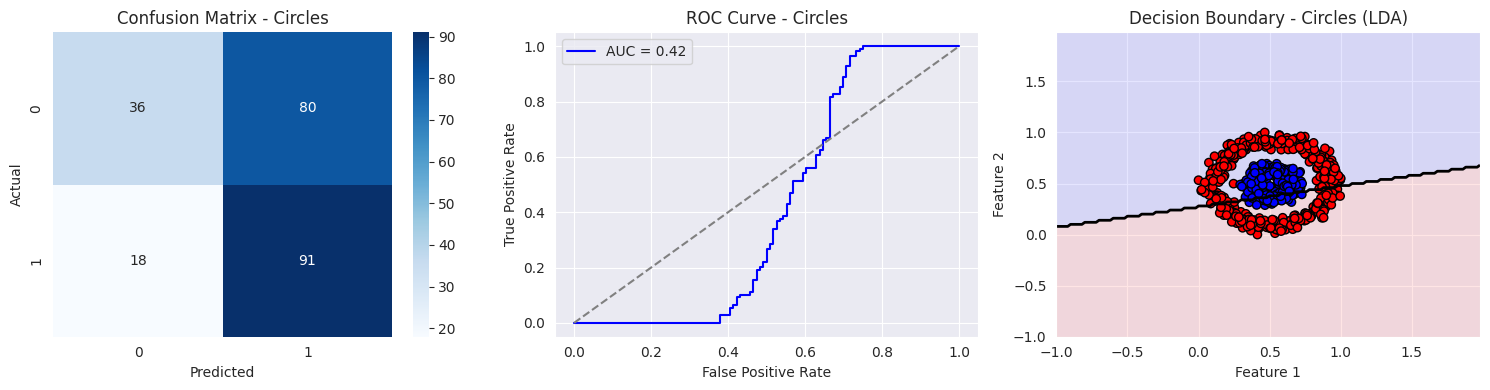

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.31      0.42       116
           1       0.53      0.83      0.65       109

    accuracy                           0.56       225
   macro avg       0.60      0.57      0.54       225
weighted avg       0.60      0.56      0.53       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - LDA
Accuracy (cross-validation): 0.5067 ± 0.0365


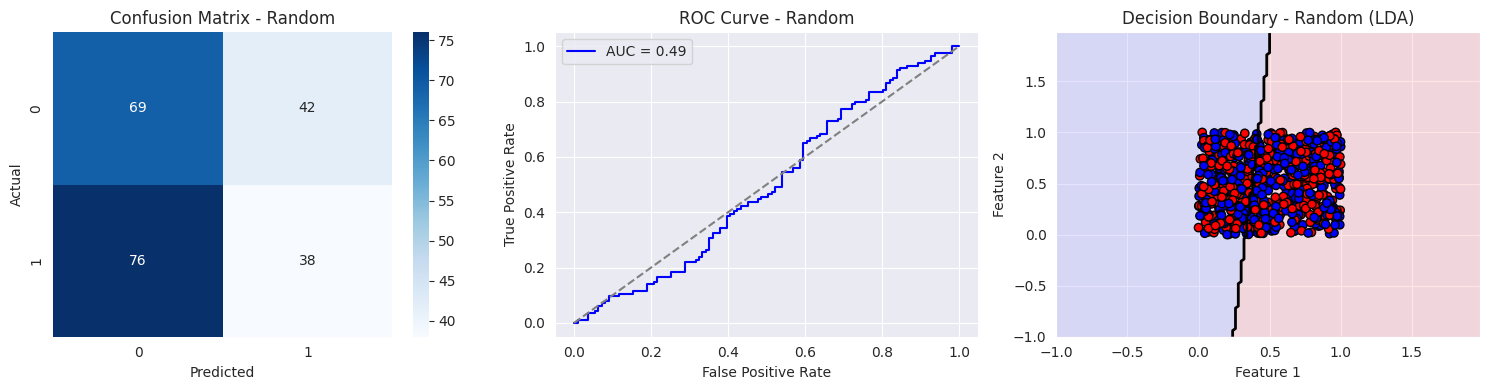

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.62      0.54       111
           1       0.47      0.33      0.39       114

    accuracy                           0.48       225
   macro avg       0.48      0.48      0.47       225
weighted avg       0.48      0.48      0.46       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Cross - LDA
Accuracy (cross-validation): 0.6467 ± 0.0000


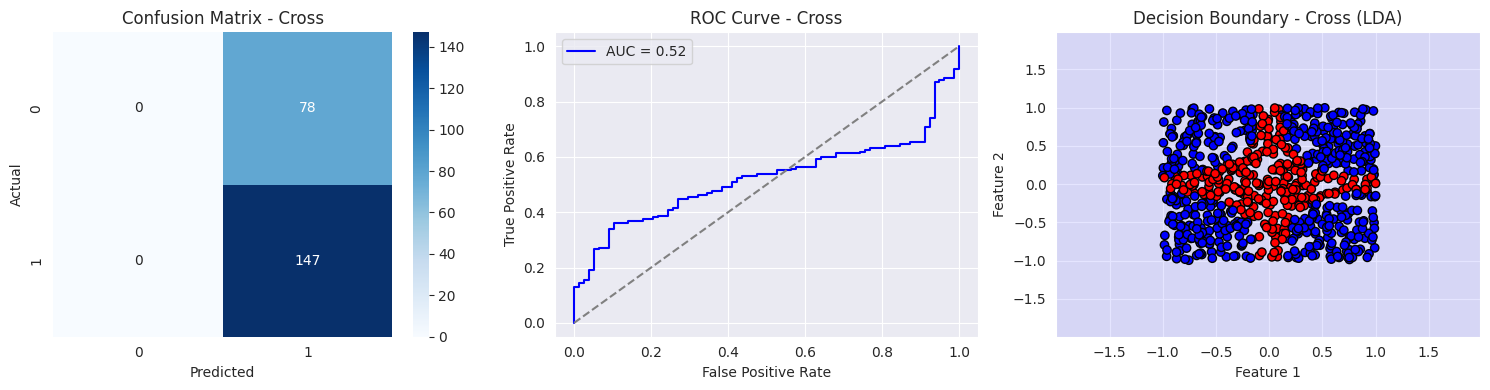

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        78
           1       0.65      1.00      0.79       147

    accuracy                           0.65       225
   macro avg       0.83      0.50      0.40       225
weighted avg       0.77      0.65      0.52       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [8]:
evaluate_model(LinearDiscriminantAnalysis(), "LDA", datasets)


Seperated - QDA
Accuracy (cross-validation): 1.0000 ± 0.0000


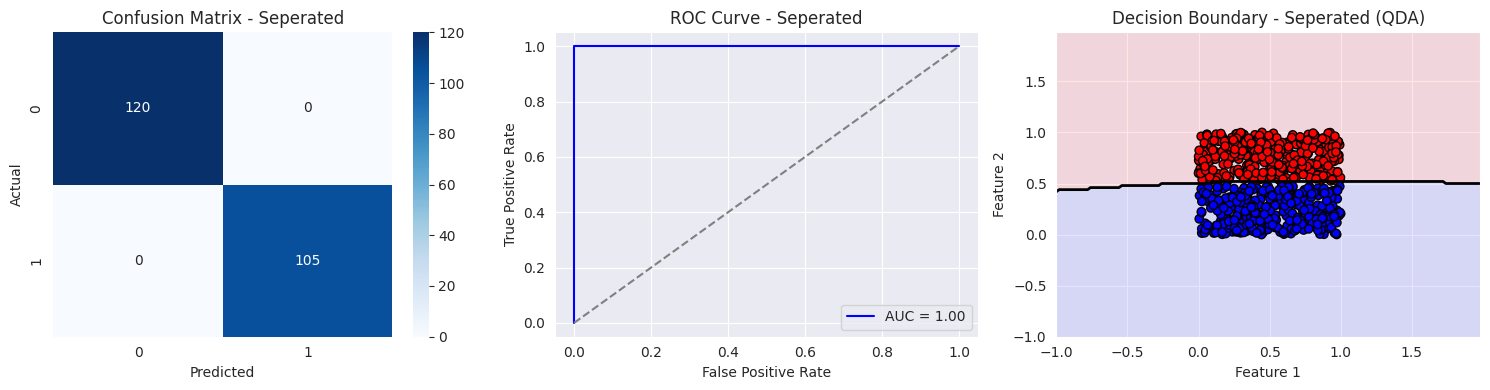

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       120
         1.0       1.00      1.00      1.00       105

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - QDA
Accuracy (cross-validation): 0.9467 ± 0.0094


/home/joaomonteiro/Desktop/ML/env_ml/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/joaomonteiro/Desktop/ML/env_ml/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/joaomonteiro/Desktop/ML/env_ml/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/joaomonteiro/Desktop/ML/env_ml/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing th

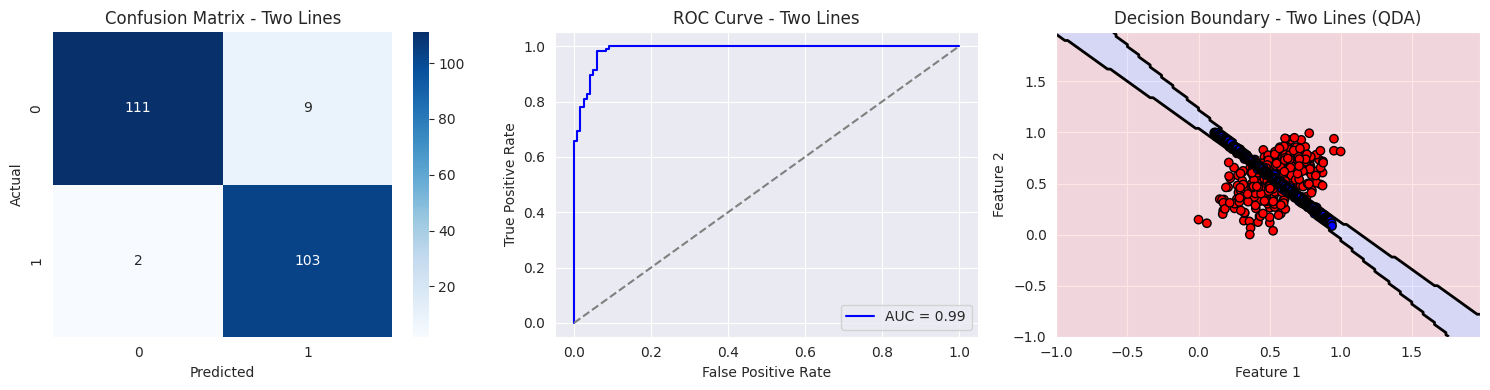

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95       120
         1.0       0.92      0.98      0.95       105

    accuracy                           0.95       225
   macro avg       0.95      0.95      0.95       225
weighted avg       0.95      0.95      0.95       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - QDA
Accuracy (cross-validation): 0.8653 ± 0.0176


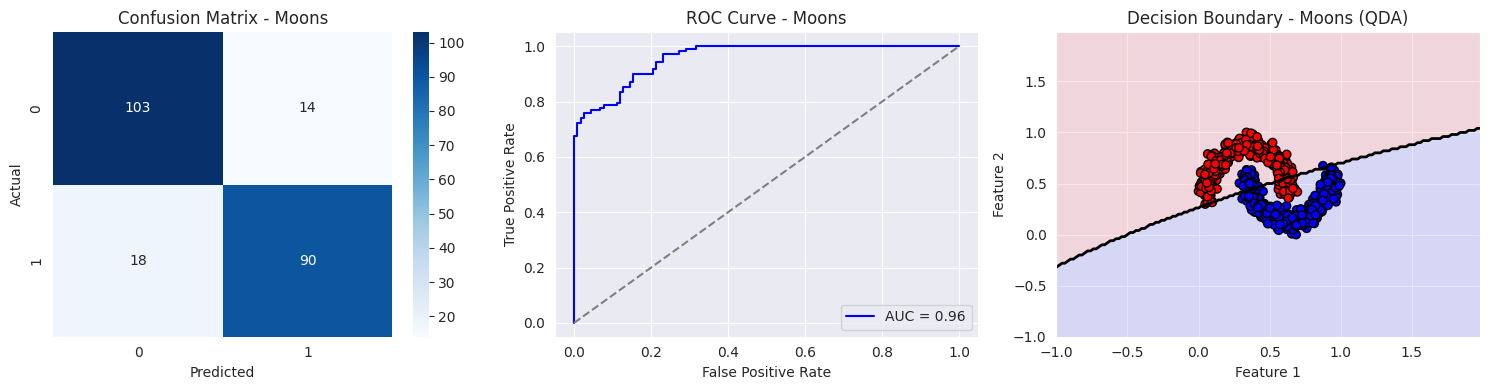

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       117
           1       0.87      0.83      0.85       108

    accuracy                           0.86       225
   macro avg       0.86      0.86      0.86       225
weighted avg       0.86      0.86      0.86       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - QDA
Accuracy (cross-validation): 0.9853 ± 0.0088


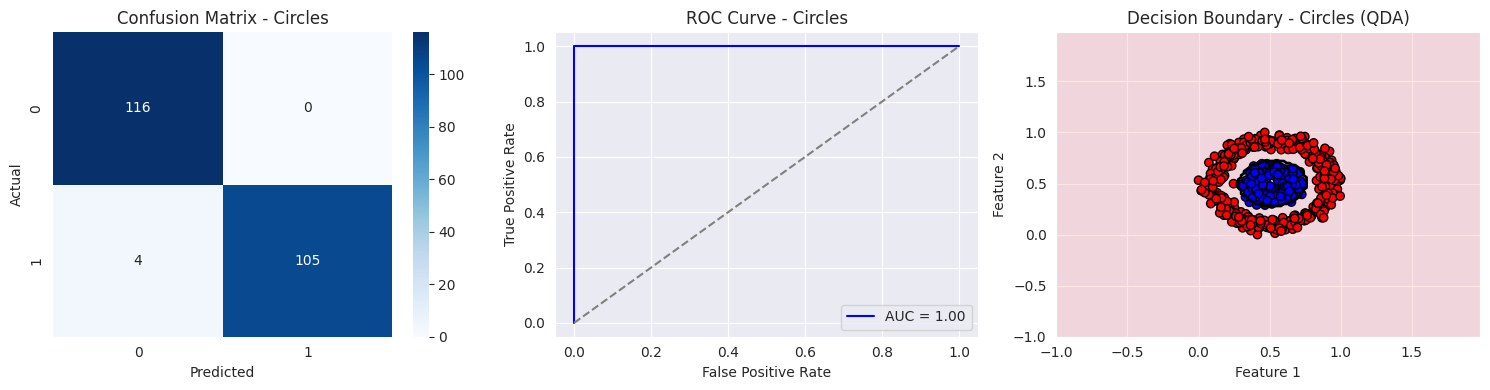

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       116
           1       1.00      0.96      0.98       109

    accuracy                           0.98       225
   macro avg       0.98      0.98      0.98       225
weighted avg       0.98      0.98      0.98       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - QDA
Accuracy (cross-validation): 0.5107 ± 0.0248


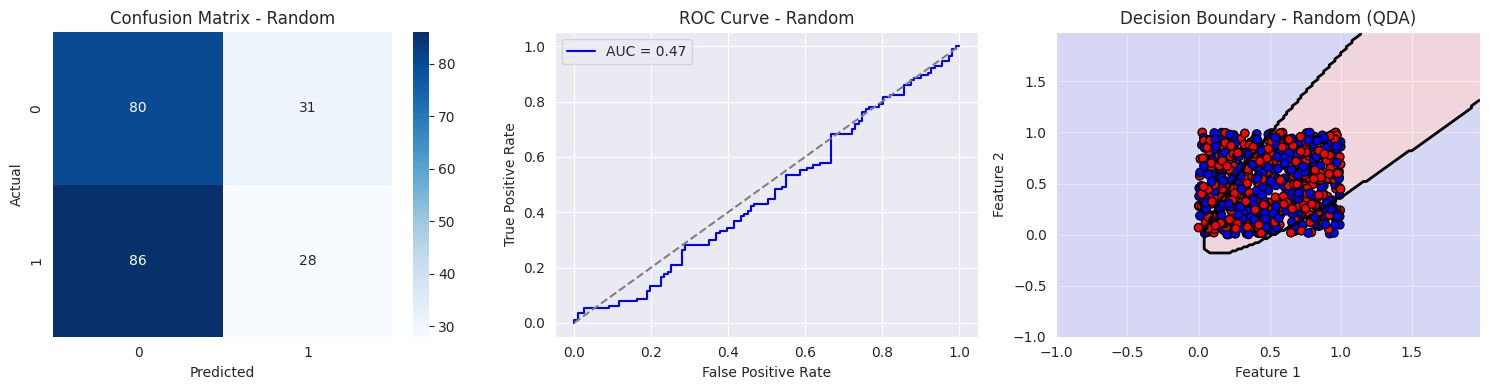

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.72      0.58       111
           1       0.47      0.25      0.32       114

    accuracy                           0.48       225
   macro avg       0.48      0.48      0.45       225
weighted avg       0.48      0.48      0.45       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Cross - QDA
Accuracy (cross-validation): 0.8187 ± 0.0217


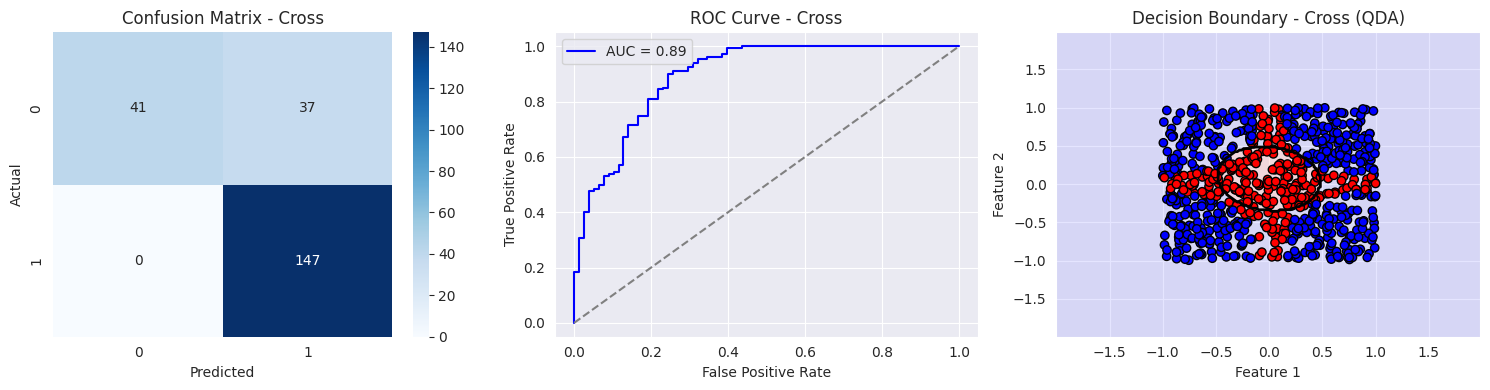

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69        78
           1       0.80      1.00      0.89       147

    accuracy                           0.84       225
   macro avg       0.90      0.76      0.79       225
weighted avg       0.87      0.84      0.82       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [9]:
evaluate_model(QuadraticDiscriminantAnalysis(), "QDA", datasets)



Seperated - Decision Tree - No Pruning
Accuracy (cross-validation): 1.0000 ± 0.0000


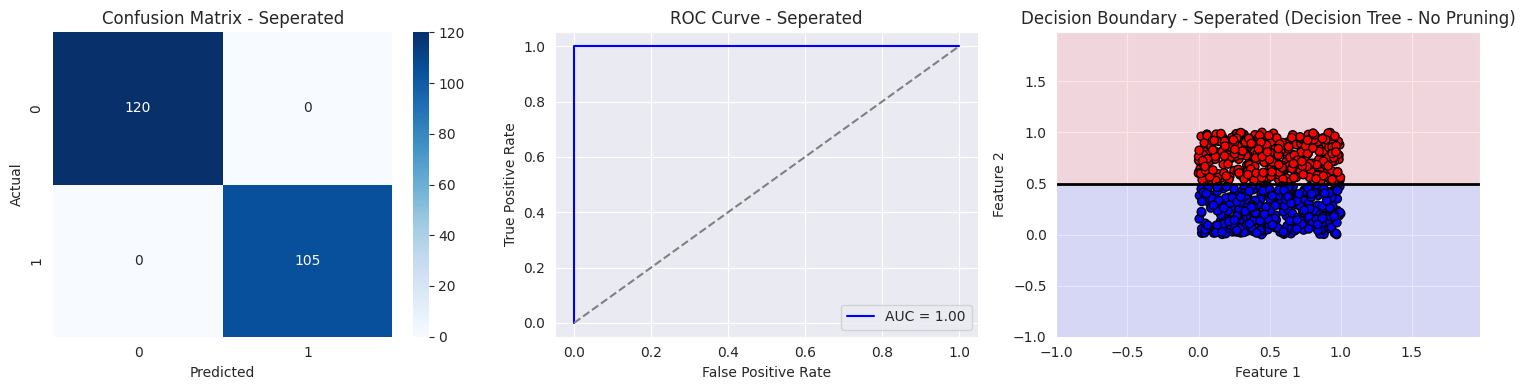

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       120
         1.0       1.00      1.00      1.00       105

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - Decision Tree - No Pruning
Accuracy (cross-validation): 0.5933 ± 0.1743


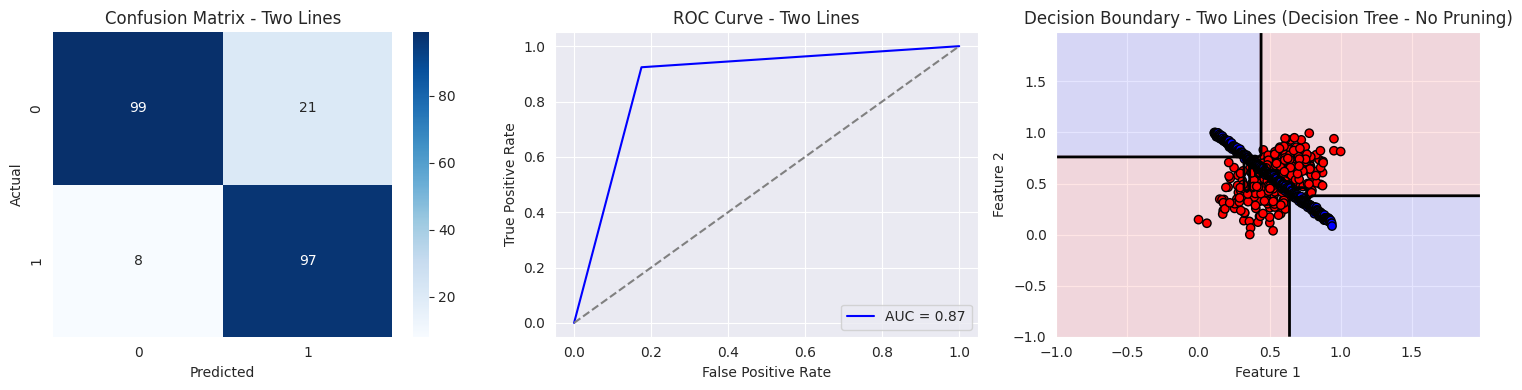

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87       120
         1.0       0.82      0.92      0.87       105

    accuracy                           0.87       225
   macro avg       0.87      0.87      0.87       225
weighted avg       0.88      0.87      0.87       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - Decision Tree - No Pruning
Accuracy (cross-validation): 0.9907 ± 0.0053


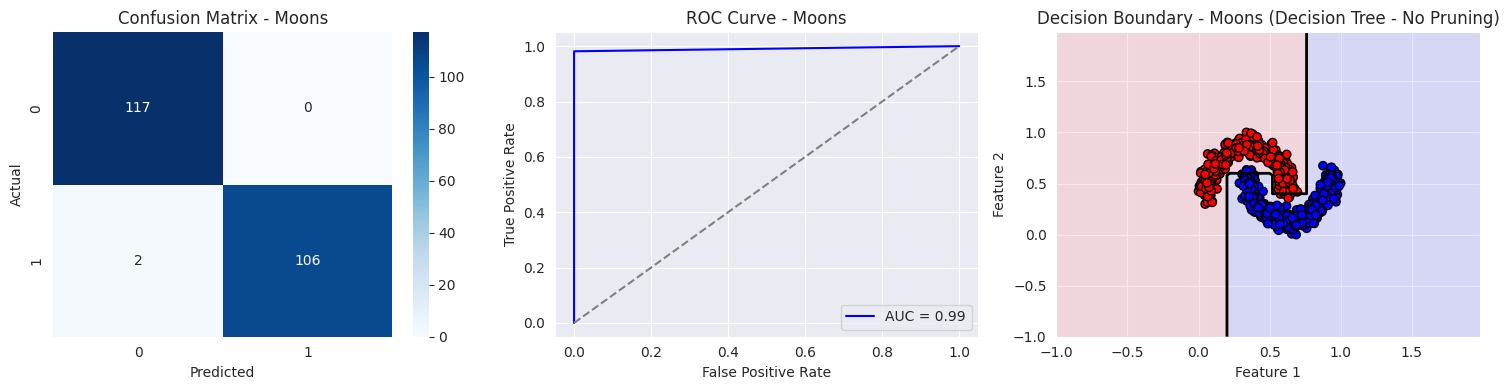

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       117
           1       1.00      0.98      0.99       108

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - Decision Tree - No Pruning
Accuracy (cross-validation): 0.9907 ± 0.0053


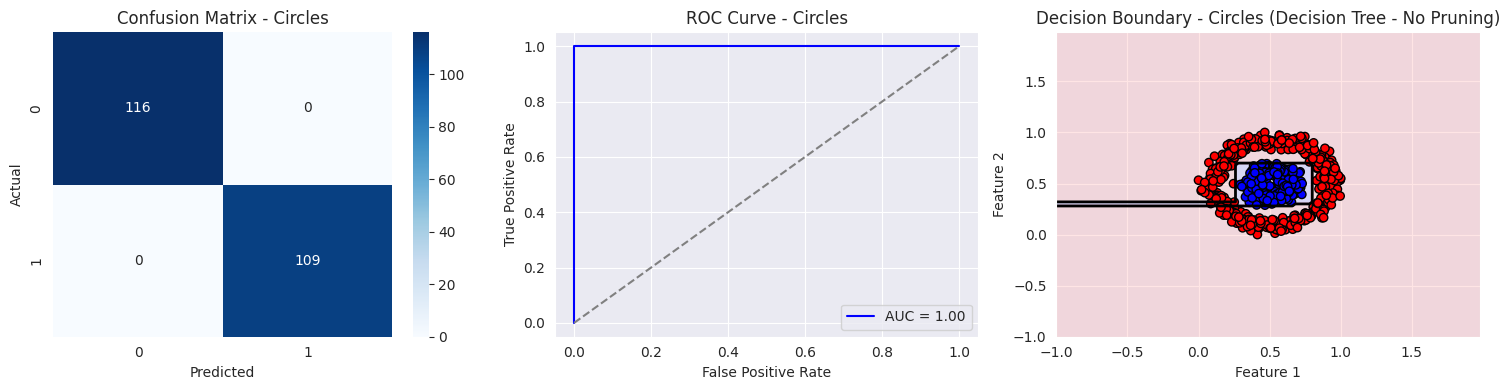

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       116
           1       1.00      1.00      1.00       109

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - Decision Tree - No Pruning
Accuracy (cross-validation): 0.4693 ± 0.0314


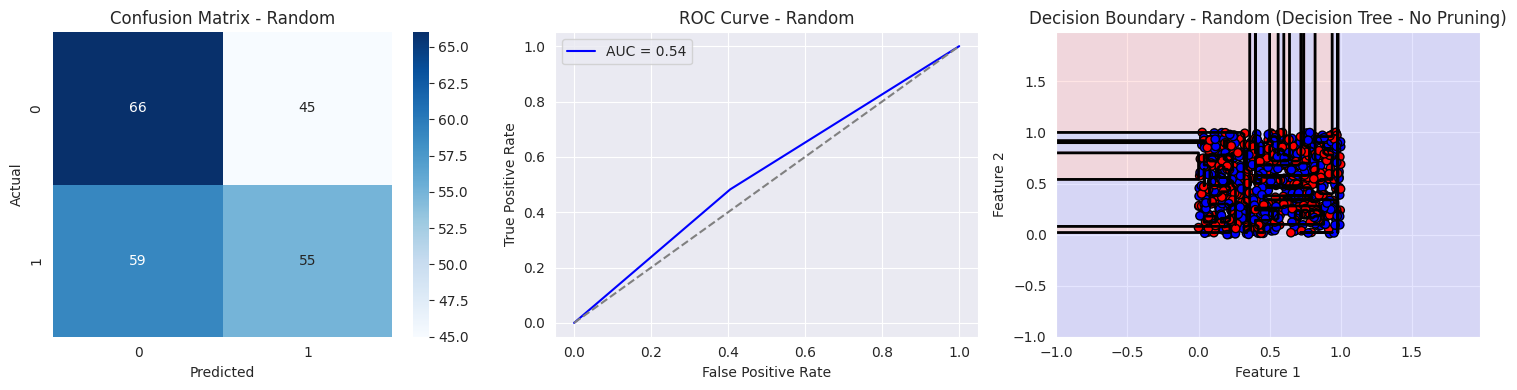

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.59      0.56       111
           1       0.55      0.48      0.51       114

    accuracy                           0.54       225
   macro avg       0.54      0.54      0.54       225
weighted avg       0.54      0.54      0.54       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Cross - Decision Tree - No Pruning
Accuracy (cross-validation): 0.9413 ± 0.0142


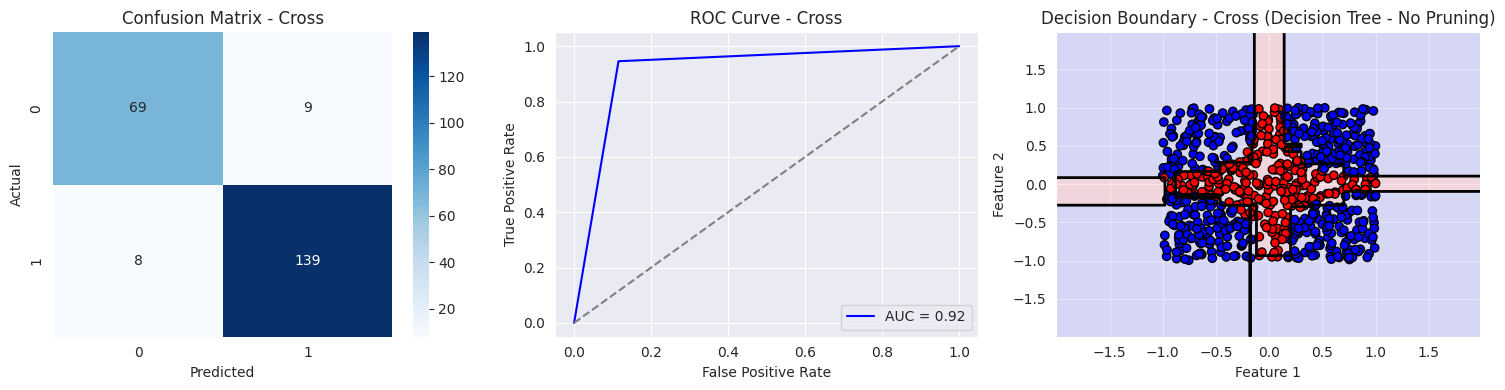

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        78
           1       0.94      0.95      0.94       147

    accuracy                           0.92       225
   macro avg       0.92      0.92      0.92       225
weighted avg       0.92      0.92      0.92       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [10]:
evaluate_model(DecisionTreeClassifier(), "Decision Tree - No Pruning", datasets)

In [11]:
from sklearn.tree import plot_tree

def plot_decision_trees_for_all_datasets(datasets, max_depth=None):
    for name, (X, y) in datasets.items():
        if len(np.unique(y)) > 2:
            continue

        model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        model.fit(X, y)

        plt.figure(figsize=(12, 6))
        plot_tree(model, filled=True, feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"])
        plt.title(f"Decision Tree - {name} ")
        plt.show()


Decision Trees without pruning:


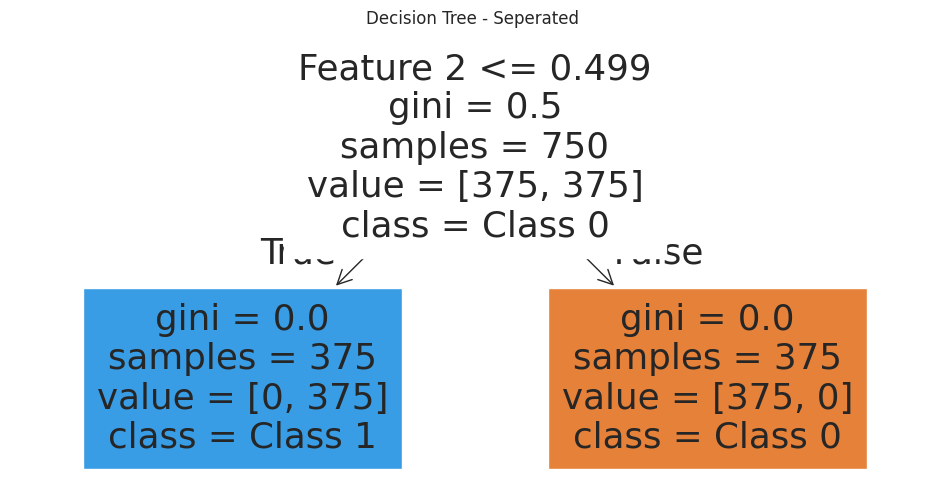

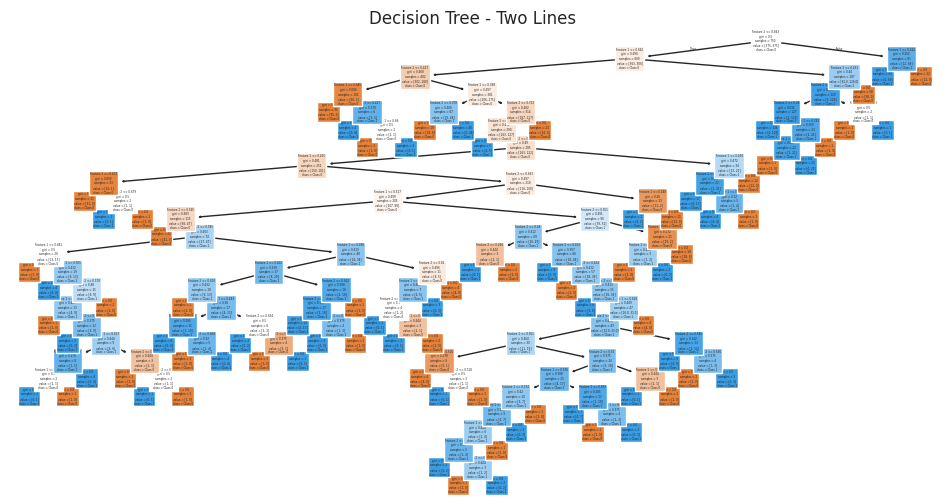

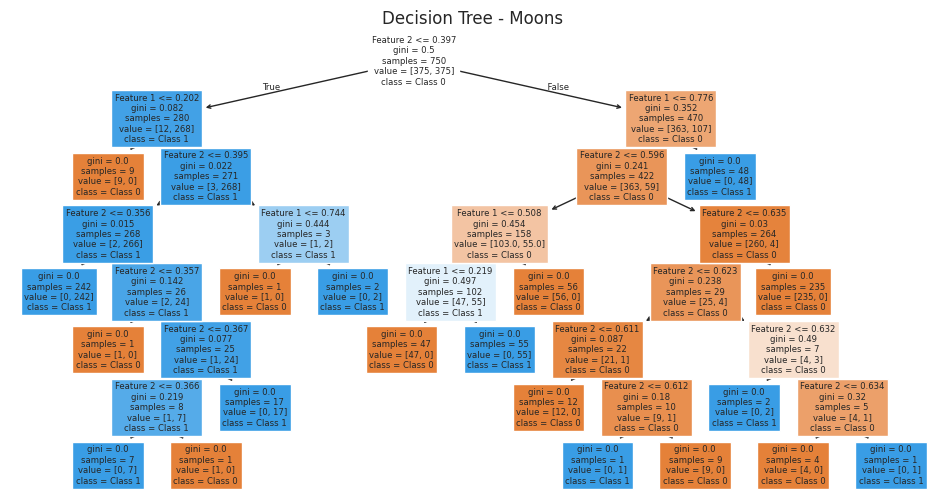

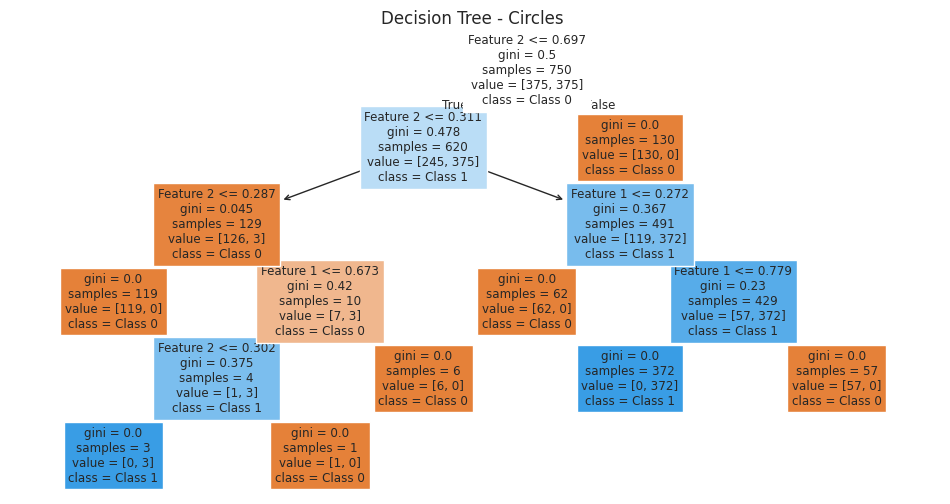

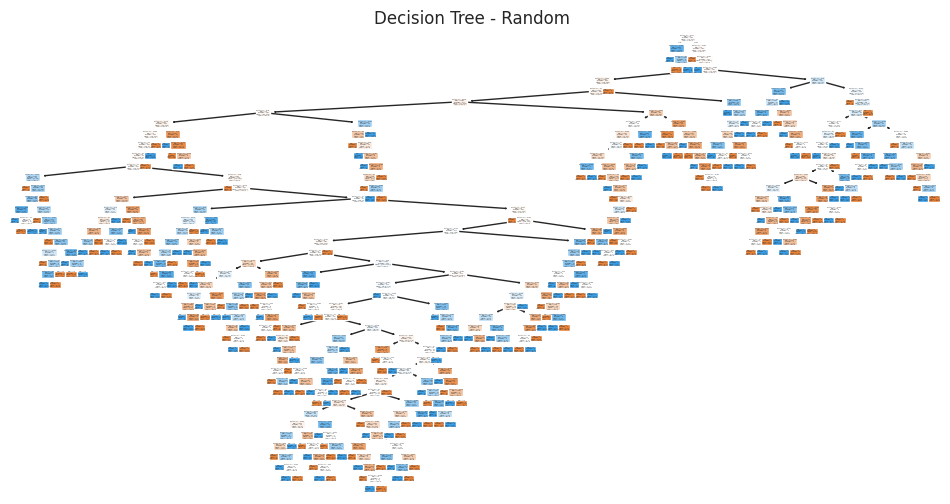

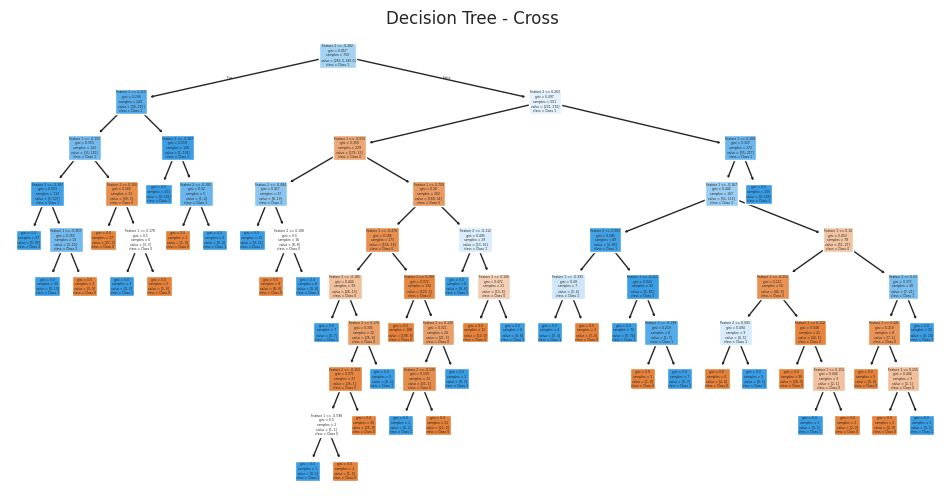

In [12]:
print("Decision Trees without pruning:")
plot_decision_trees_for_all_datasets(datasets)


Seperated - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 1.0000 ± 0.0000


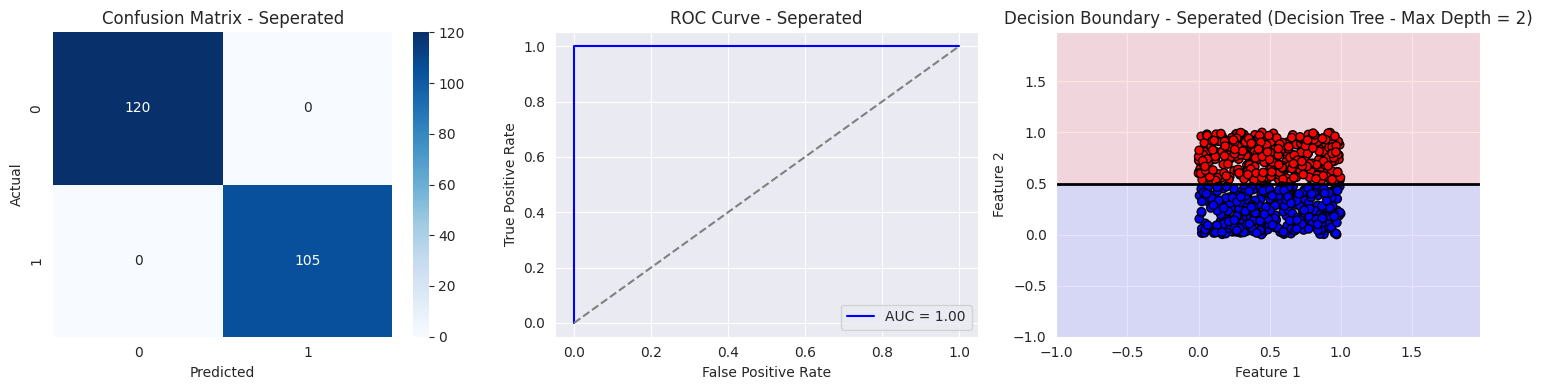

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       120
         1.0       1.00      1.00      1.00       105

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.4560 ± 0.0445


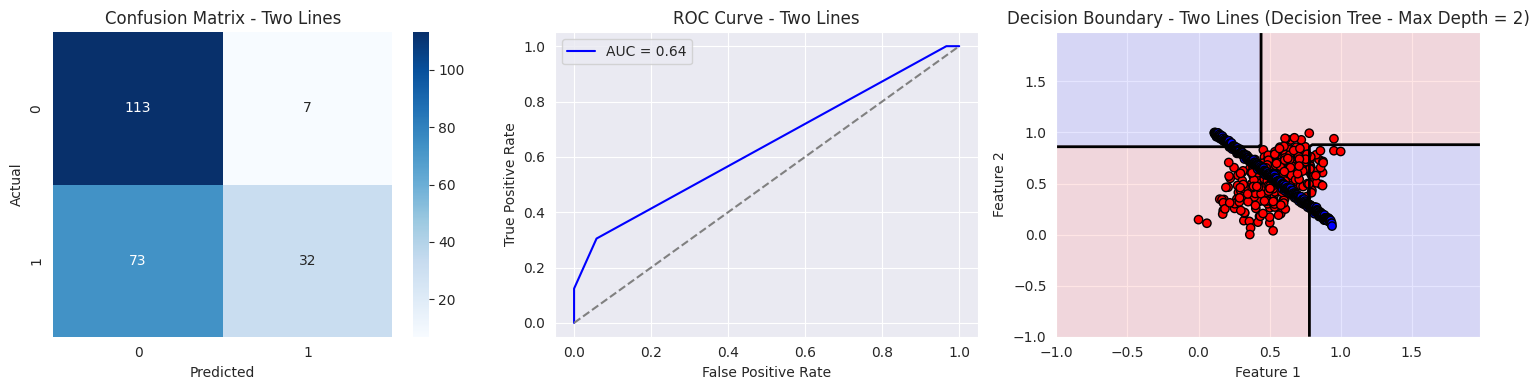

Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.94      0.74       120
         1.0       0.82      0.30      0.44       105

    accuracy                           0.64       225
   macro avg       0.71      0.62      0.59       225
weighted avg       0.71      0.64      0.60       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.9107 ± 0.0116


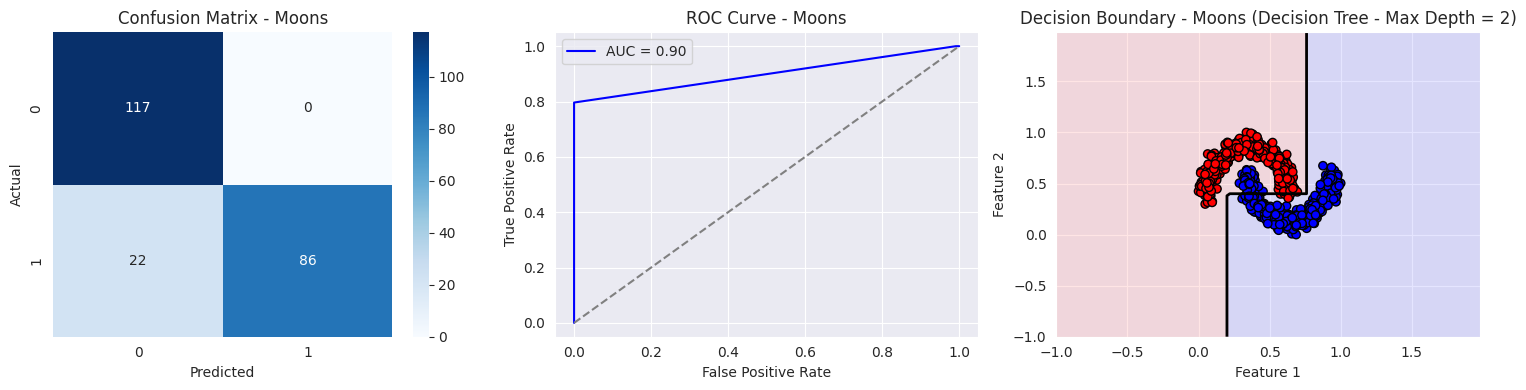

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       117
           1       1.00      0.80      0.89       108

    accuracy                           0.90       225
   macro avg       0.92      0.90      0.90       225
weighted avg       0.92      0.90      0.90       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.8240 ± 0.0282


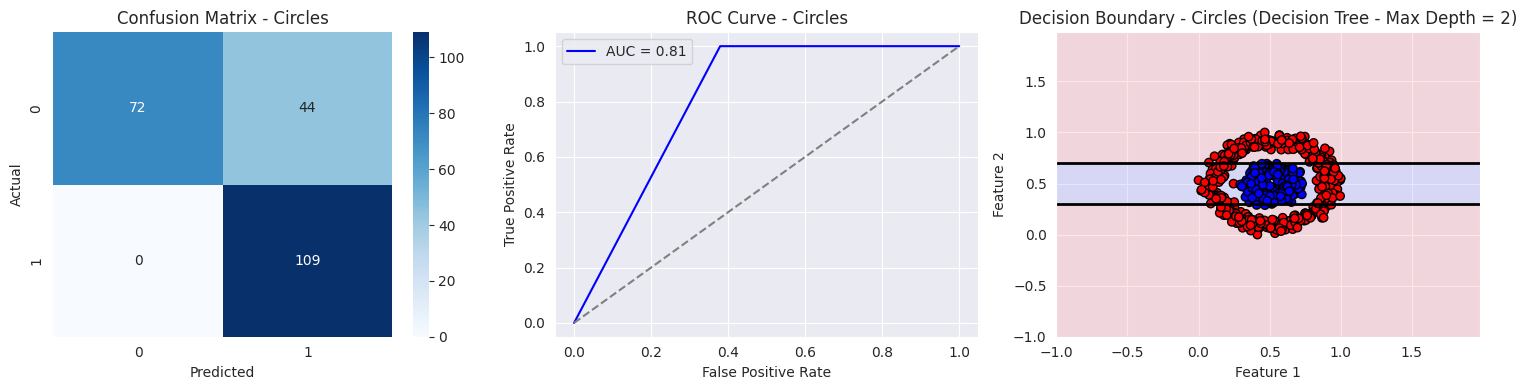

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77       116
           1       0.71      1.00      0.83       109

    accuracy                           0.80       225
   macro avg       0.86      0.81      0.80       225
weighted avg       0.86      0.80      0.80       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.5000 ± 0.0174


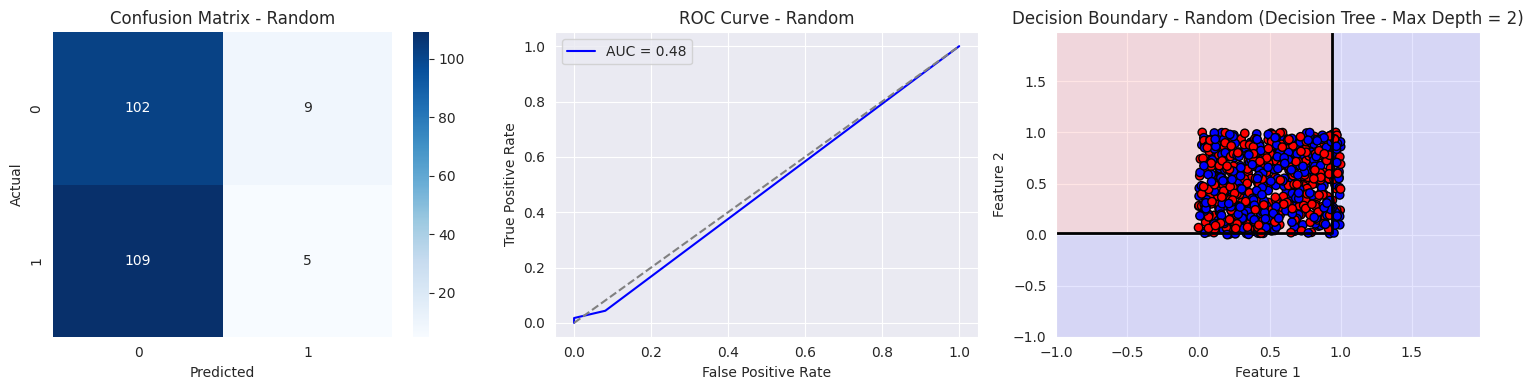

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.92      0.63       111
           1       0.36      0.04      0.08       114

    accuracy                           0.48       225
   macro avg       0.42      0.48      0.36       225
weighted avg       0.42      0.48      0.35       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Cross - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.7893 ± 0.0323


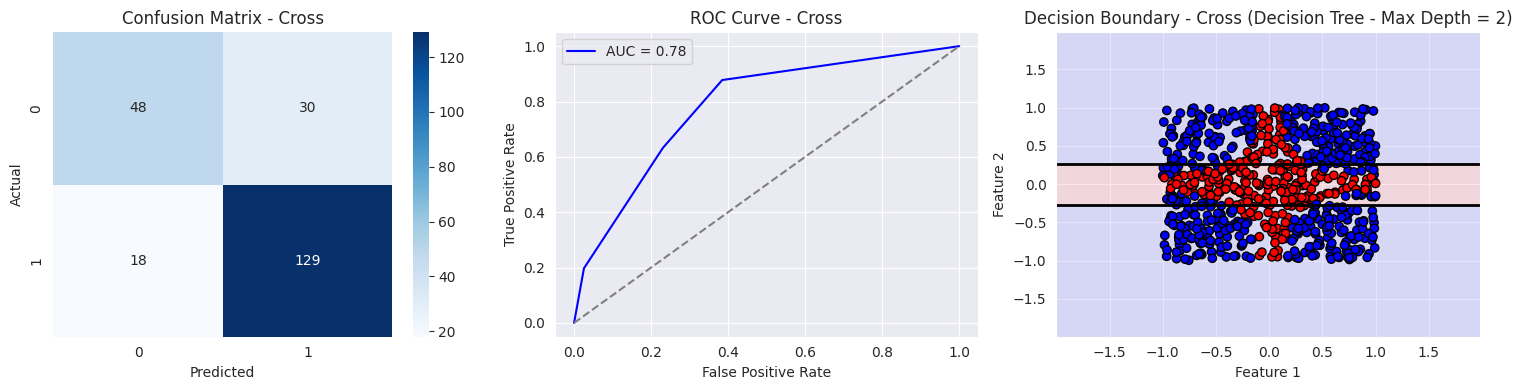

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        78
           1       0.81      0.88      0.84       147

    accuracy                           0.79       225
   macro avg       0.77      0.75      0.75       225
weighted avg       0.78      0.79      0.78       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [13]:
evaluate_model(DecisionTreeClassifier(max_depth=2), "Decision Tree - Max Depth = 2", datasets)


Decision Trees with max_depth=2:


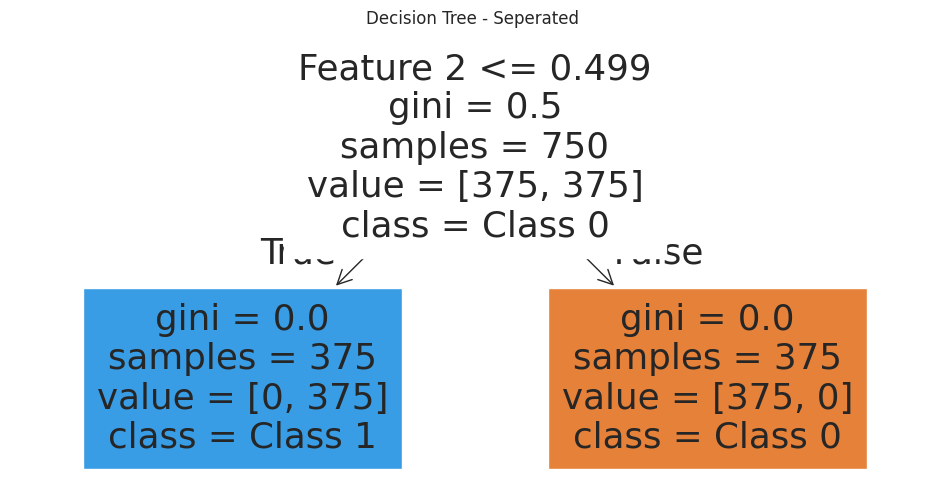

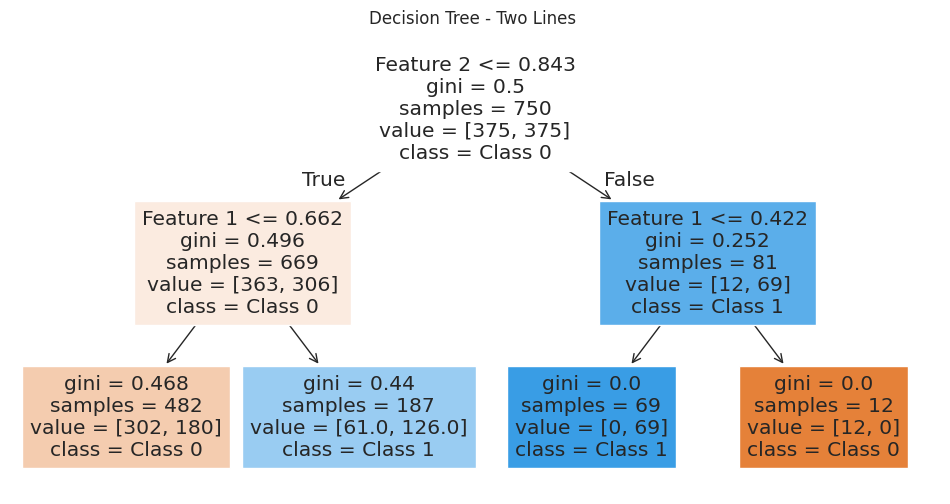

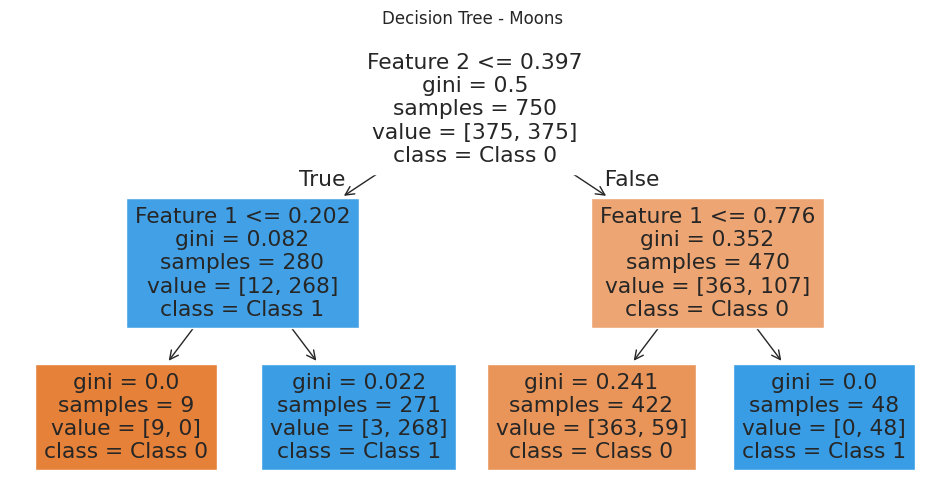

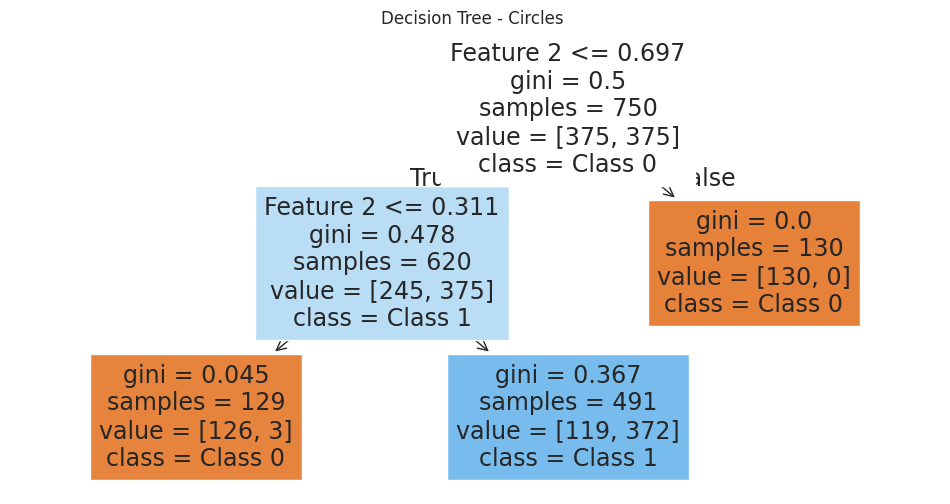

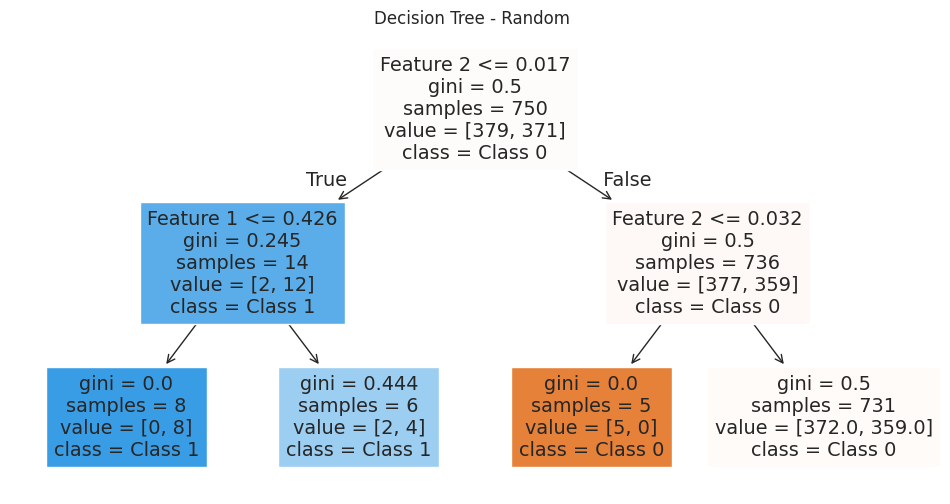

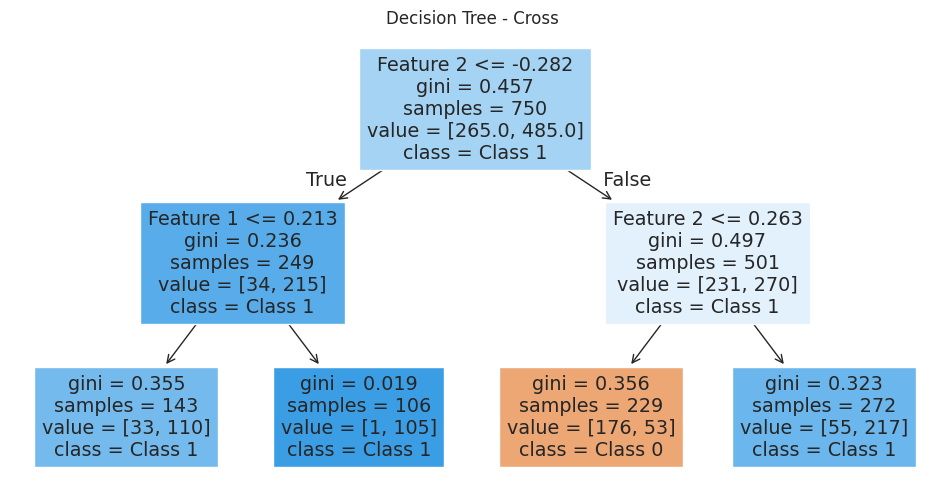

In [14]:
print("\nDecision Trees with max_depth=2:")
plot_decision_trees_for_all_datasets(datasets, max_depth=2)


Seperated - SVM Linear
Accuracy (cross-validation): 0.9987 ± 0.0027


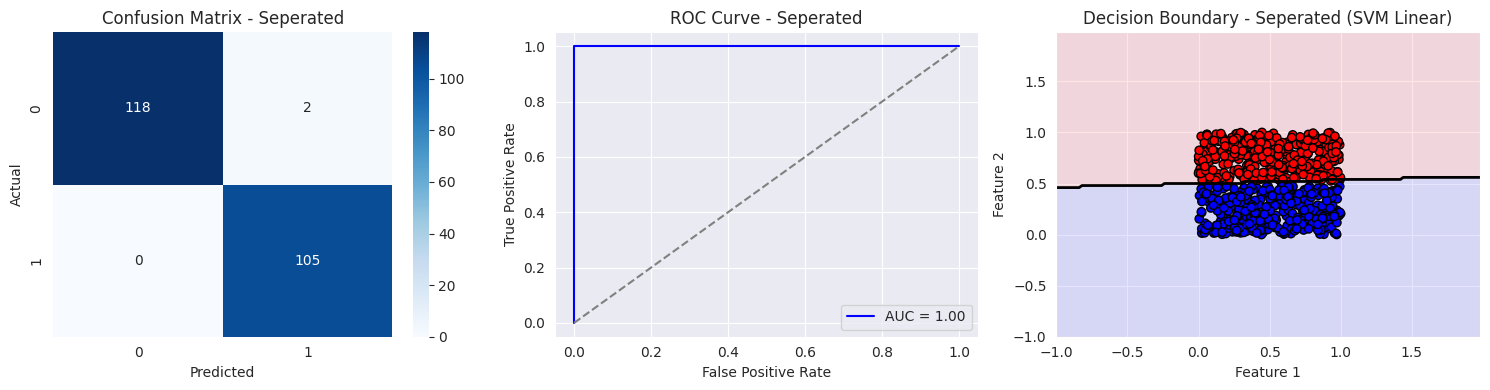

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       120
         1.0       0.98      1.00      0.99       105

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - SVM Linear
Accuracy (cross-validation): 0.4707 ± 0.0425


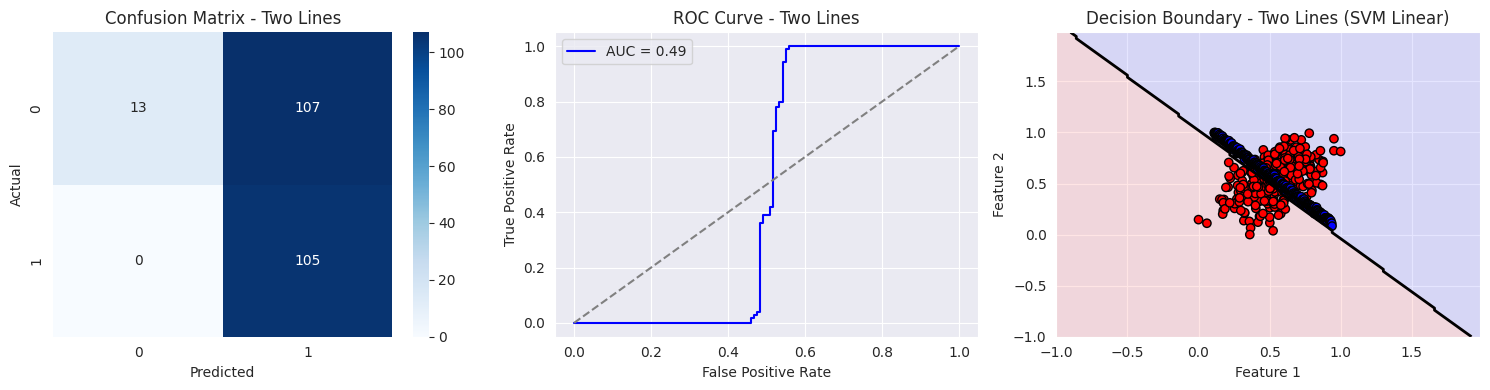

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.11      0.20       120
         1.0       0.50      1.00      0.66       105

    accuracy                           0.52       225
   macro avg       0.75      0.55      0.43       225
weighted avg       0.76      0.52      0.41       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - SVM Linear
Accuracy (cross-validation): 0.8627 ± 0.0196


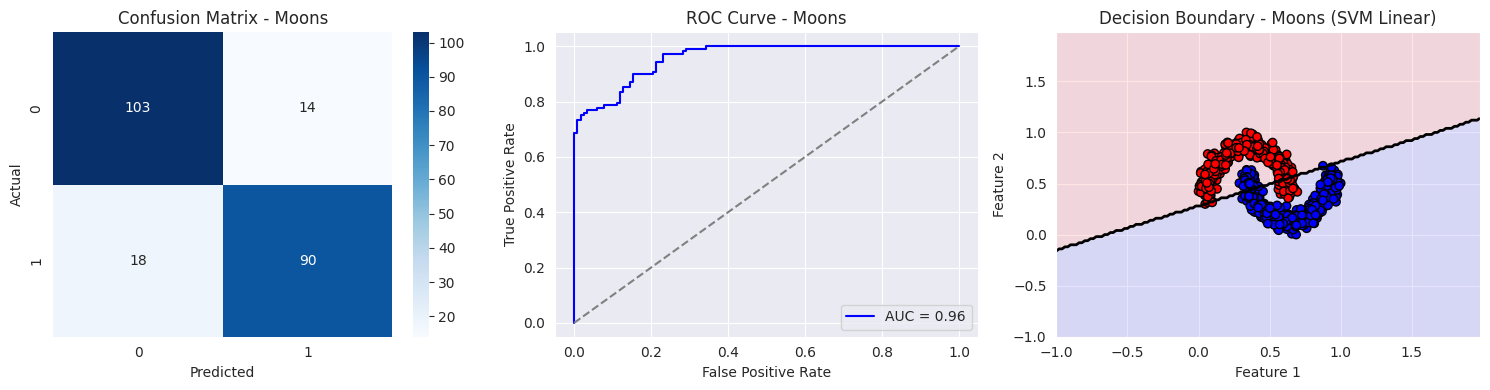

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       117
           1       0.87      0.83      0.85       108

    accuracy                           0.86       225
   macro avg       0.86      0.86      0.86       225
weighted avg       0.86      0.86      0.86       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - SVM Linear
Accuracy (cross-validation): 0.6253 ± 0.0165


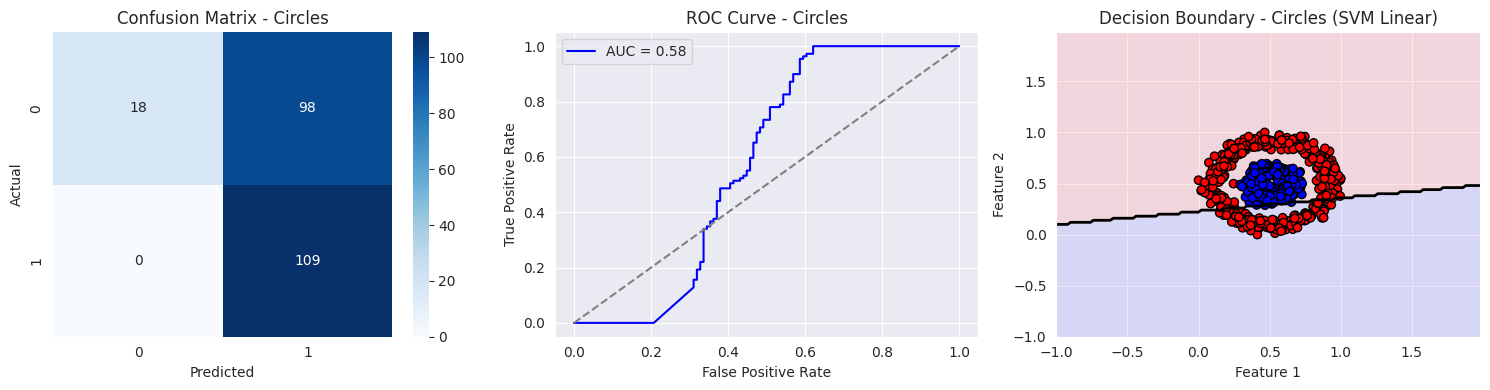

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.16      0.27       116
           1       0.53      1.00      0.69       109

    accuracy                           0.56       225
   macro avg       0.76      0.58      0.48       225
weighted avg       0.77      0.56      0.47       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - SVM Linear
Accuracy (cross-validation): 0.4960 ± 0.0328


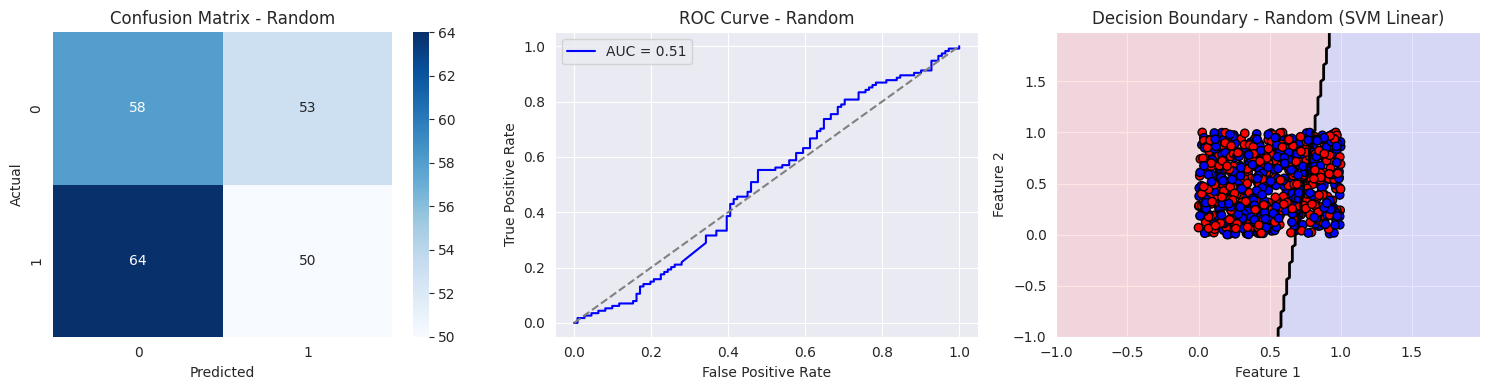

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.52      0.50       111
           1       0.49      0.44      0.46       114

    accuracy                           0.48       225
   macro avg       0.48      0.48      0.48       225
weighted avg       0.48      0.48      0.48       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Cross - SVM Linear
Accuracy (cross-validation): 0.6467 ± 0.0000


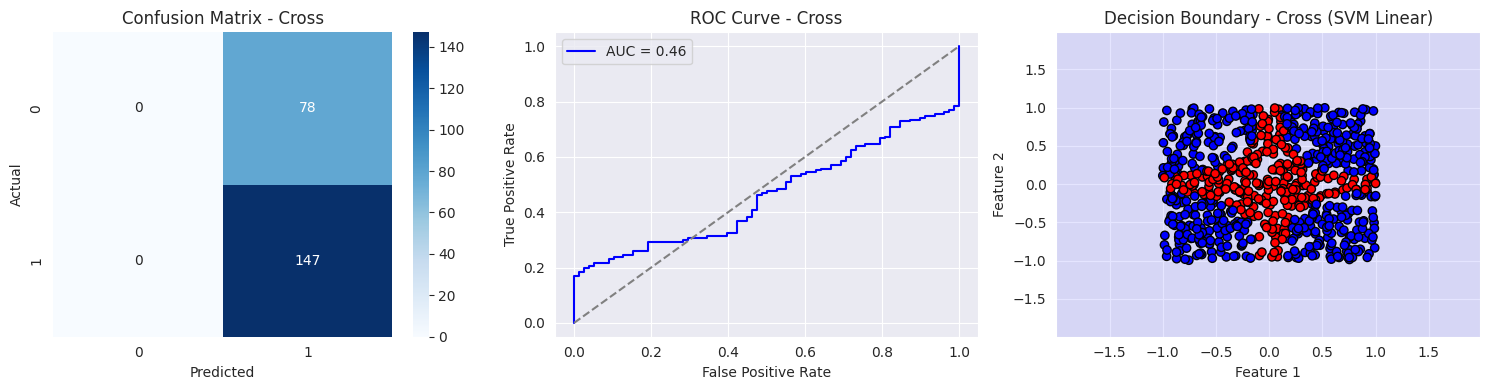

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        78
           1       0.65      1.00      0.79       147

    accuracy                           0.65       225
   macro avg       0.83      0.50      0.40       225
weighted avg       0.77      0.65      0.52       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [15]:
evaluate_model(SVC(kernel="linear", probability=True), "SVM Linear", datasets)


Seperated - SVM RBF
Accuracy (cross-validation): 1.0000 ± 0.0000


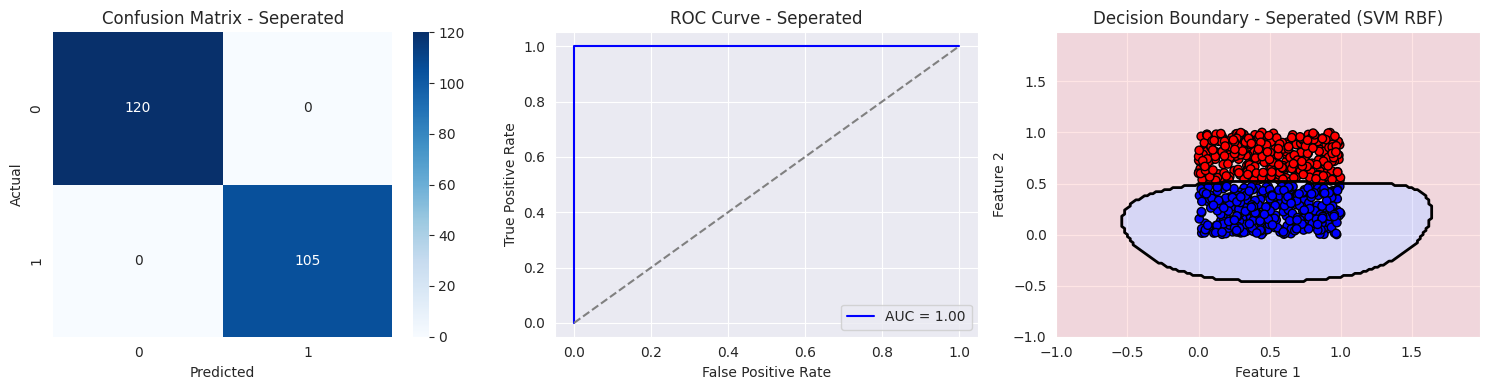

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       120
         1.0       1.00      1.00      1.00       105

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - SVM RBF
Accuracy (cross-validation): 0.6413 ± 0.1245


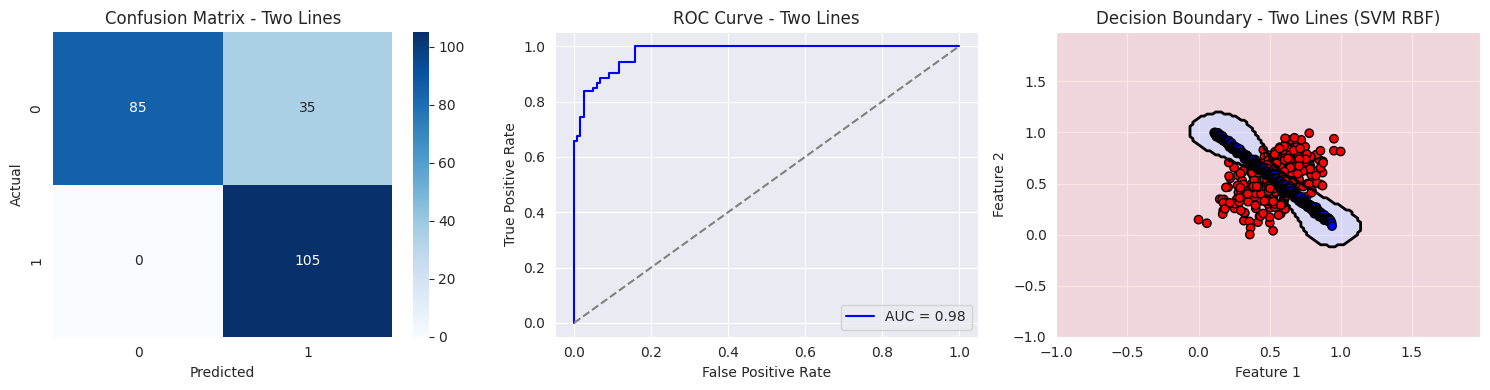

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83       120
         1.0       0.75      1.00      0.86       105

    accuracy                           0.84       225
   macro avg       0.88      0.85      0.84       225
weighted avg       0.88      0.84      0.84       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - SVM RBF
Accuracy (cross-validation): 1.0000 ± 0.0000


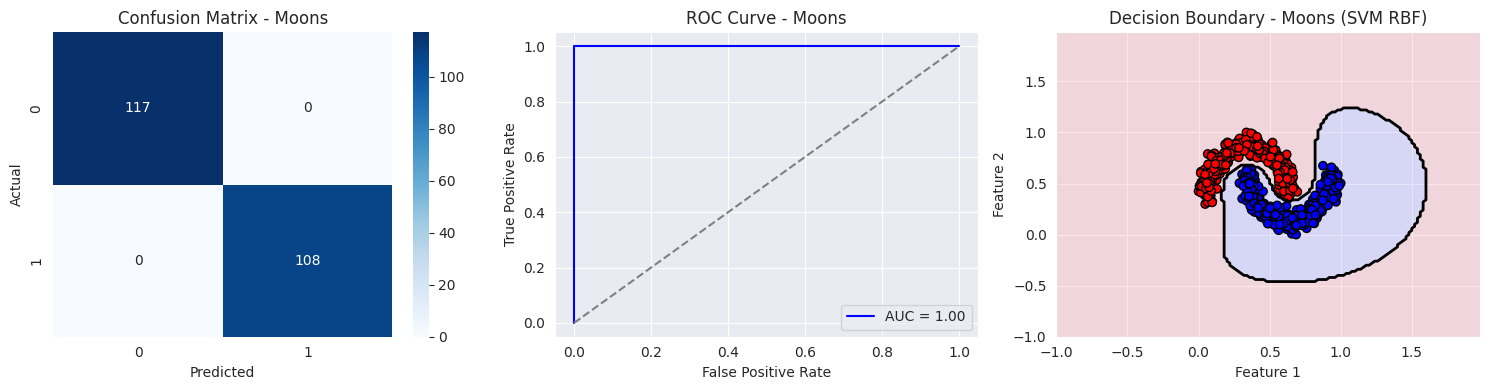

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       117
           1       1.00      1.00      1.00       108

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - SVM RBF
Accuracy (cross-validation): 0.9987 ± 0.0027


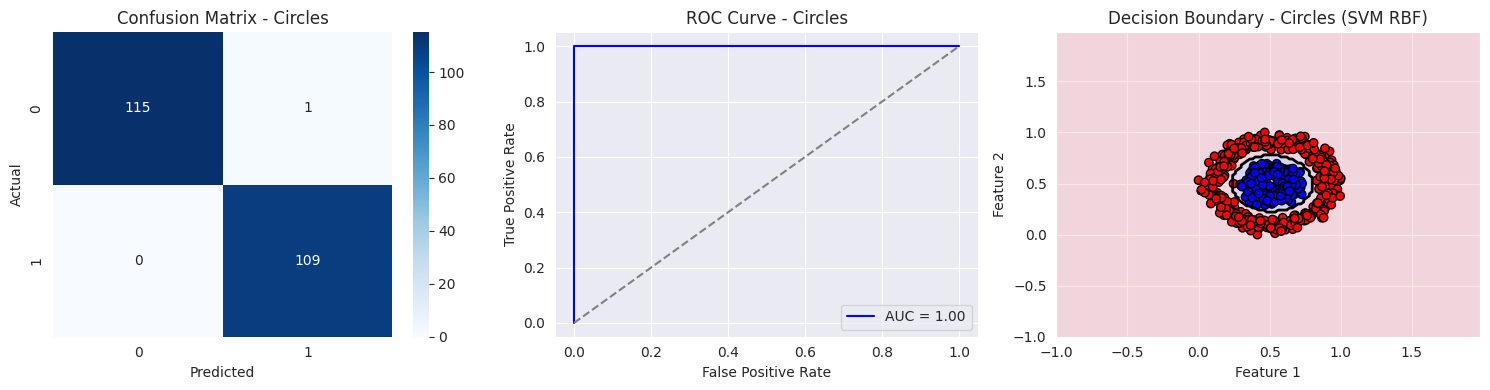

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       116
           1       0.99      1.00      1.00       109

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - SVM RBF
Accuracy (cross-validation): 0.5307 ± 0.0116


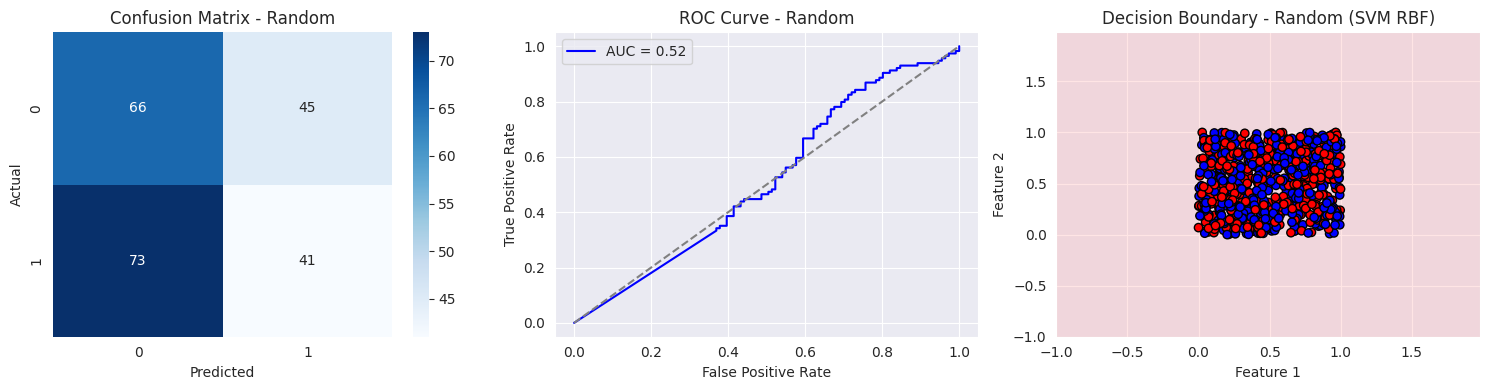

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.59      0.53       111
           1       0.48      0.36      0.41       114

    accuracy                           0.48       225
   macro avg       0.48      0.48      0.47       225
weighted avg       0.48      0.48      0.47       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Cross - SVM RBF
Accuracy (cross-validation): 0.8693 ± 0.0209


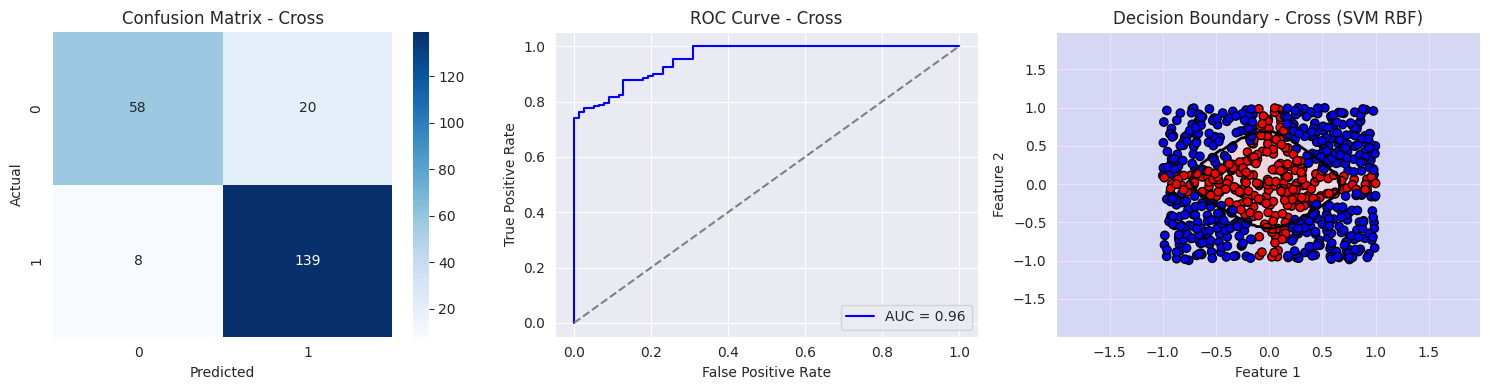

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81        78
           1       0.87      0.95      0.91       147

    accuracy                           0.88       225
   macro avg       0.88      0.84      0.86       225
weighted avg       0.88      0.88      0.87       225

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [16]:
evaluate_model(SVC(kernel="rbf", probability=True), "SVM RBF", datasets)
